# Analiza i predikcija kratkoročnih logaritamskih prinosa S&P 500 indeksa primenom modela vremenskih serija

**Autor:** Miloš Trišić RA39/2023  
**Predmet:** Numerički algoritmi i numerički softver (NANS)  

---

## 0. Uvod i opis problema

**S&P 500** (Standard & Poor's 500) je berzanski indeks koji prati kretanje 500 najvećih američkih kompanija po tržišnoj kapitalizaciji. Ovaj indeks je kapitalizacijski ponderisan, što znači da kompanije poput Apple-a, Microsoft-a i NVIDIA-e imaju veći uticaj na njegovo kretanje od manjih kompanija. Zbog toga ga mnogi ekonomisti smatraju najboljim pokazateljem stanja američke ekonomije u celini.

Cilj ovog projekta je ispitati u kojoj meri savremeni modeli vremenskih serija mogu da se primene za analizu i kratkoročnu predikciju kretanja ovog indeksa (tačnije njegovih logaritamskih prinosa "log-returns" - objašnjeno u nastavku). Konkretno:

- Analiza i identifikacija osnovnih karakteristika serije (trend, sezonalnost, cikličnost, šum)
- Predikcija pomoću **ARIMA** i **Facebook Prophet** modela
- Modelovanje volatilnosti pomoću **GARCH** modela
- Deskriptivna **PCA** analiza kompanija i sektora koji najviše doprinose varijansi tržišta

### Zbog čega je modelovanje ovakvih pojava problematično?

Finansijska tržišta su po prirodi veoma kompleksna – na vrednost indeksa istovremeno utiče veliki broj faktora (makroekonomski pokazatelji, geopolitika, raspoloženje investitora, izveštaji kompanija, kao i mnogobrojni nepredvidivi faktori...). Zbog toga ćemo videti da modeli vremenskih serija imaju ograničene performanse u smislu tačne predikcije vrednosti, ali nam i dalje daju korisne uvide o **strukturi serije** i **dinamici volatilnosti**.

### Horizont predikcije

Predikciju vršimo za **1 trading dan unapred**, koristeći walk-forward evaluaciju na test skupu. Razlog za ovako kratak horizont je propagacija greške – što dalje predviđamo, interval neizvesnosti eksponencijalno raste, pa su predikcije duže od 2-3 dana za finansijske serije uglavnom nepouzdane.

---
## 1. Učitavanje podataka i pretprocesiranje

Pre nego što krenemo na analizu i modelovanje, učitavamo podatke, sređujemo ih i delimo na skupove za trening, validaciju i testiranje.

### Podela podataka

Kod vremenskih serija podela mora biti **strogo hronološka** – ne možemo koristiti  random-split kao kod klasičnih ML problema. Ako bi podaci iz budućnosti ušli u trening skup, model bi imao informacije koje u realnosti ne bi imao u trenutku predikcije (*data leakage*). Dakle, koristimo sledeću podelu:

| Skup | Period | Napomena |
|------|--------|----------|
| **Train** | 2014-12-23 → 2022-12-30 | Uključuje COVID krizu (2020) i tržišni pad (2022) |
| **Validation** | 2023-01-03 → 2023-12-29 | Za određivanje parametara modela |
| **Test** | 2024-01-02 → 2024-12-20 | Finalna evaluacija |

Validacioni skup koristimo tokom razvoja za odabir parametara (npr. p, d, q za ARIMA). Test skup koristimo **samo jednom**, na kraju, za finalno poređenje karakteristika dobijenih modela.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '.')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid')

print('Biblioteke uspešno učitane.')

Biblioteke uspešno učitane.


In [2]:
from src.preprocessing import load_and_prepare, print_split_info

train, val, test, companies = load_and_prepare(
    index_path     = 'data/sp500_index.csv',
    companies_path = 'data/sp500_companies.csv'
)

print_split_info(train, val, test)

       Train: 2014-12-23 → 2022-12-30 | 2020 trading dana (80.3%)
  Validation: 2023-01-03 → 2023-12-29 |  250 trading dana (9.9%)
        Test: 2024-01-02 → 2024-12-20 |  246 trading dana (9.8%)
      Ukupno: 2516 trading dana


### Pregled učitanih tabela

Koristimo tabele :
- `sp500_index.csv` – dnevne zatvarajuće vrednosti indeksa za svaki trading dan (vikendi i praznici su prirodno odsutni)
- `sp500_companies.csv` – metapodaci o kompanijama: sektor, industrija, tržišna kapitalizacija, ponder u indeksu itd. Ova tabela koristiće nam u PCA analizi.

In [3]:
print('=== Prvih 5 redova (train) ===')
display(train.head())

print('\n=== Poslednjih 5 redova (train) ===')
display(train.tail())

print('\n=== Prvih 5 redova (test) ===')
display(test.head())

=== Prvih 5 redova (train) ===


S&P500  log_return
Date                           
2014-12-23  2082.17    0.001745
2014-12-24  2081.88   -0.000139
2014-12-26  2088.77    0.003304
2014-12-29  2090.57    0.000861
2014-12-30  2080.35   -0.004901


=== Poslednjih 5 redova (train) ===


S&P500  log_return
Date                           
2022-12-23  3844.82    0.005851
2022-12-27  3829.25   -0.004058
2022-12-28  3783.22   -0.012093
2022-12-29  3849.28    0.017311
2022-12-30  3839.50   -0.002544


=== Prvih 5 redova (test) ===


S&P500  log_return
Date                           
2024-01-02  4742.83   -0.005677
2024-01-03  4704.81   -0.008049
2024-01-04  4688.68   -0.003434
2024-01-05  4697.24    0.001824
2024-01-08  4763.54    0.014016

In [4]:
cols = ['Symbol', 'Shortname', 'Sector', 'Marketcap', 'Weight']
print(f'Broj kompanija: {len(companies)}')
print(f'Broj sektora:   {companies["Sector"].nunique()}')
print()
display(companies[cols].head(10))

Broj kompanija: 502
Broj sektora:   11



Symbol                    Shortname                  Sector      Marketcap  \
0   AAPL                   Apple Inc.              Technology  3846819807232   
1   NVDA           NVIDIA Corporation              Technology  3298803056640   
2   MSFT        Microsoft Corporation              Technology  3246068596736   
3   AMZN             Amazon.com, Inc.       Consumer Cyclical  2365033807872   
4  GOOGL                Alphabet Inc.  Communication Services  2351625142272   
5   GOOG                Alphabet Inc.  Communication Services  2351623045120   
6   META         Meta Platforms, Inc.  Communication Services  1477457739776   
7   TSLA                  Tesla, Inc.       Consumer Cyclical  1351627833344   
8   AVGO                Broadcom Inc.              Technology  1031217348608   
9  BRK-B  Berkshire Hathaway Inc. New      Financial Services   978776031232   

     Weight  
0  0.069209  
1  0.059350  
2  0.058401  
3  0.042550  
4  0.042309  
5  0.042309  
6  0.026581  
7  0.024317  
8  0.018553  
9  0.017609

In [5]:
#Agregacija broja kompanija i ukupne težine (kolona Weights) po sektorima
sektor_count = companies.groupby('Sector').agg(
    Broj_kompanija=('Symbol', 'count'),
    Weight=('Weight', 'sum')
).sort_values('Weight', ascending=False).round(4)

display(sektor_count)

Broj_kompanija  Weight
Sector                                        
Technology                          82  0.3110
Communication Services              22  0.1404
Financial Services                  67  0.1279
Consumer Cyclical                   55  0.1146
Healthcare                          62  0.0934
Industrials                         70  0.0677
Consumer Defensive                  37  0.0585
Energy                              22  0.0288
Utilities                           32  0.0226
Real Estate                         31  0.0195
Basic Materials                     22  0.0156

---
## 2. Vizualizacija i eksplorativna analiza podataka (EDA)

### 2.1 Zašto ne modelujemo originalne vrednosti indeksa direktno?

Pre nego što transformišemo podatke, pogledajmo kako izgleda originalna vrednost S&P 500 indeksa kroz ceo posmatrani period. Na osnovu onoga što vidimo, donećemo zaključke o tome šta zapravo treba da modelujemo.

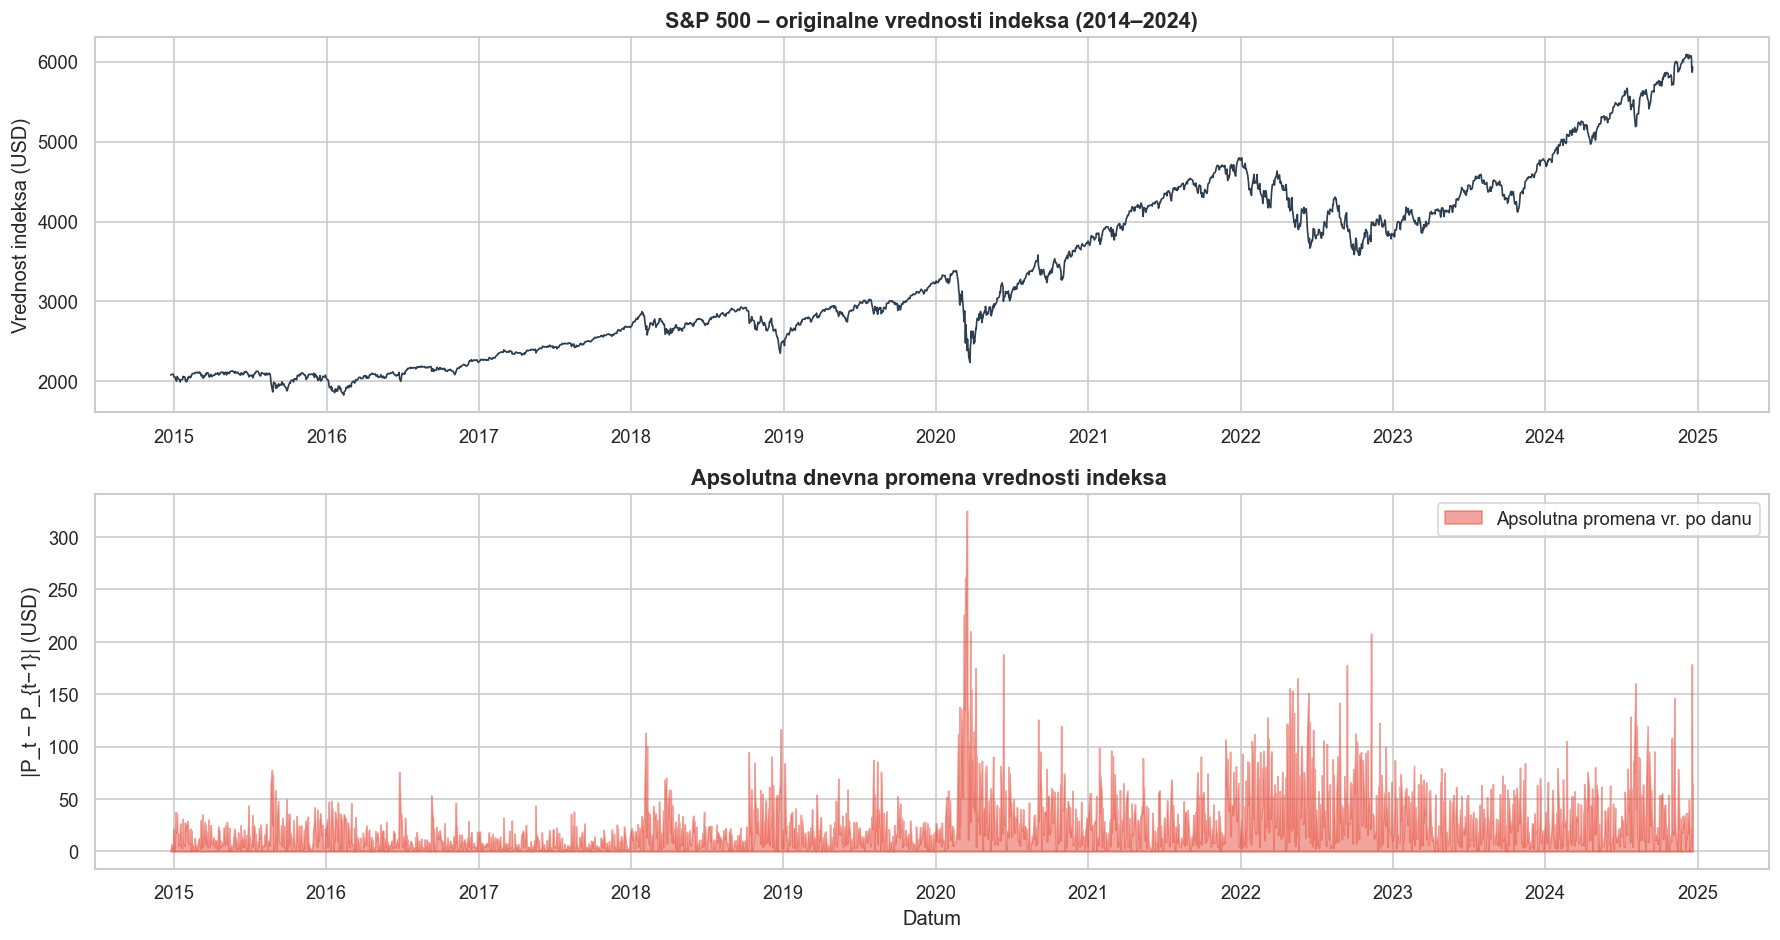

In [6]:
full_df = pd.concat([train, val, test])

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# ── Gornji grafik: originalne vrednosti ─────────────────────────────────────────
axes[0].plot(full_df.index, full_df['S&P500'], color='#2c3e50', linewidth=1.0)
axes[0].set_title('S&P 500 – originalne vrednosti indeksa (2014–2024)',
                   fontsize=13, fontweight='bold')
axes[0].set_ylabel('Vrednost indeksa (USD)')

# ── Donji grafik: apsolutna dnevna promena ─────────────────────────────
abs_changes = full_df['S&P500'].diff().abs()
axes[1].fill_between(full_df.index, abs_changes,
                     color='#e74c3c', alpha=0.5, label='Apsolutna promena vr. po danu')
axes[1].set_title('Apsolutna dnevna promena vrednosti indeksa ',
                   fontsize=13, fontweight='bold')
axes[1].set_ylabel('|P_t − P_{t−1}| (USD)')
axes[1].set_xlabel('Datum')
axes[1].legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()

Sa grafika možemo uočiti dva problema koja direktnu primenu modela na vrednost indeksa čine problematičnom :

1. **Jasan rastući trend** – indeks je porastao sa ~2000 na ~6000 USD tokom posmatranog perioda. Serija nema konstantnu srednju vrednost, što znači da **nije stacionarna**. Stacionarnost je osnovna pretpostavka ARIMA i srodnih modela, pa direktna primena na originalnu vrednost indeksa nije moguća.

2. **Varijansa raste sa trendom** – apsolutne dnevne promene su neuporedivo veće u 2024. nego 2015. Ovo ukazuje na **multiplikativni karakter** serije.

Oba problema rešavamo jednom transformacijom – prelaskom na logaritamske prinose.

### 2.2 Prelaz na logaritamske prinose (log-returns)

Umesto cena, modelujem **logaritamske dnevne prinose**:

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) = \ln(P_t) - \ln(P_{t-1})$$

Ova transformacija direktno rešava oba problema uočena na prethodnom grafiku:

- **Uklanja trend** – log-returns su centrirani oko nule. 

- **Stabilizuje varijansu** – logaritmovanje pretvara multiplikativni model u aditivni: log(T · S · C · R) = log(T) + log(S) + log(C) + log(R), čime se oscilacije normalizuju.
- **Aditivnost** – višednevni prinos dobijamo prostim sabiranjem dnevnih log-returns, što olakšava interpretaciju.

Pogledajmo kako serija izgleda nakon transformacije.

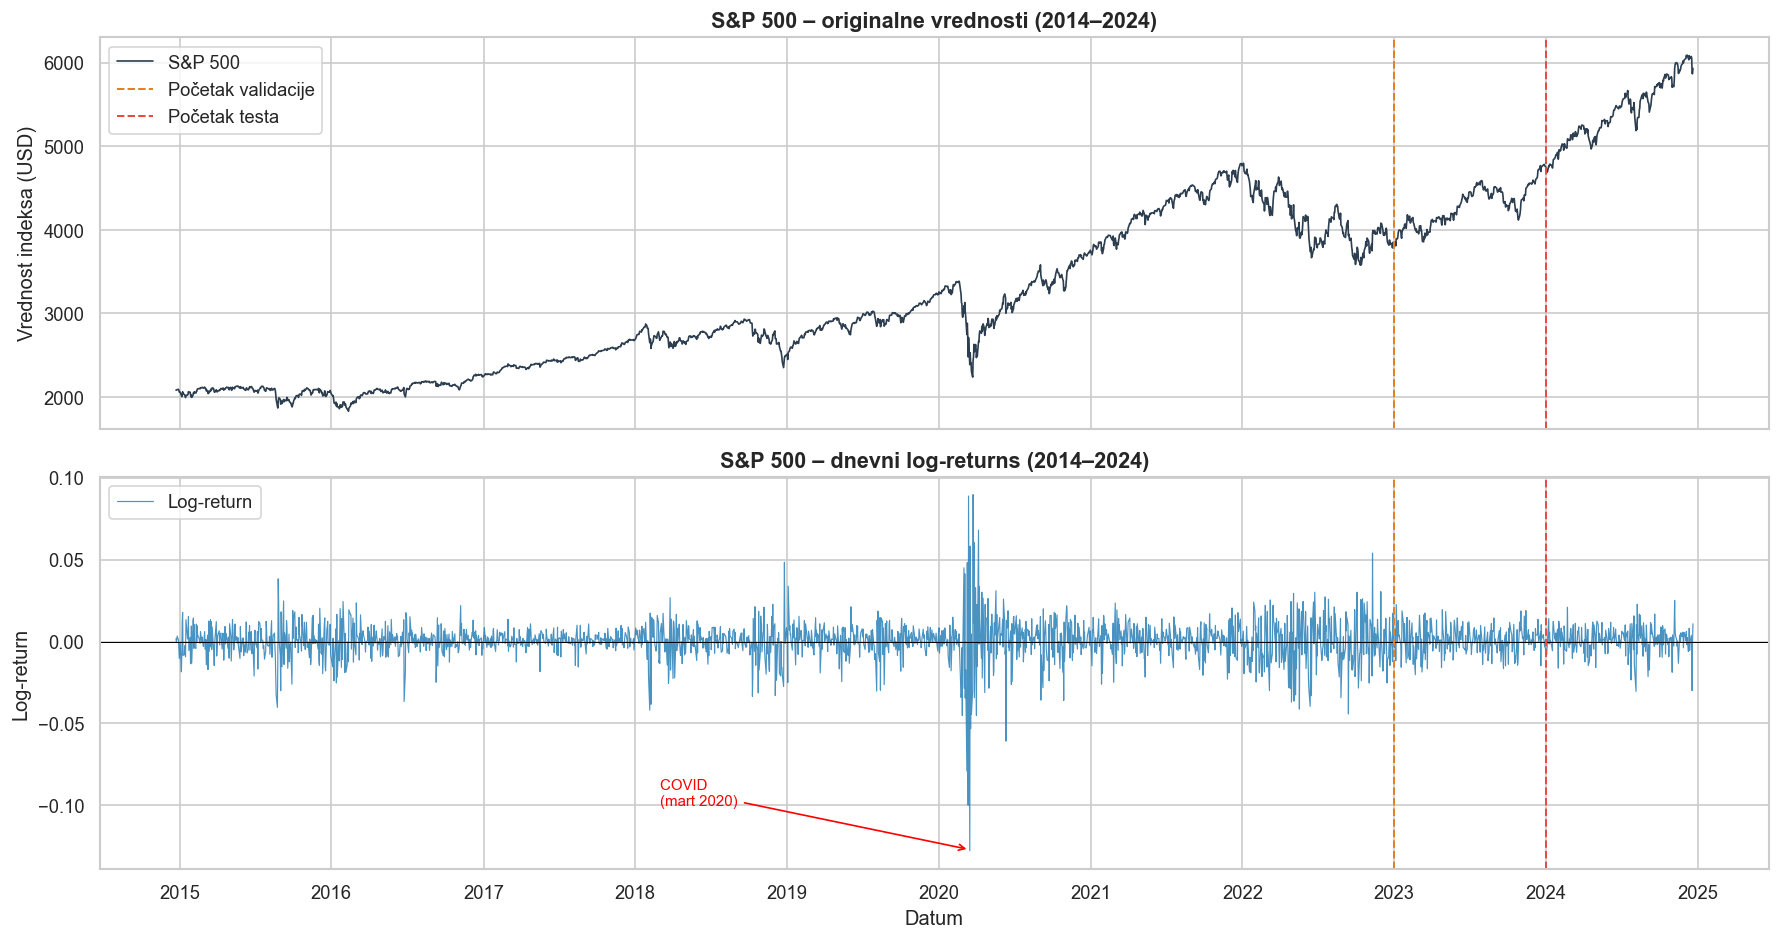

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# ── Gornji: cene sa oznakom skupova ──────────────────────────────────
axes[0].plot(full_df.index, full_df['S&P500'],
             color='#2c3e50', linewidth=1.0, label='S&P 500')
axes[0].axvline(pd.Timestamp('2023-01-01'), color='#e67e22',
                linestyle='--', linewidth=1.2, label='Početak validacije')
axes[0].axvline(pd.Timestamp('2024-01-01'), color='#e74c3c',
                linestyle='--', linewidth=1.2, label='Početak testa')
axes[0].set_ylabel('Vrednost indeksa (USD)')
axes[0].set_title('S&P 500 – originalne vrednosti (2014–2024)', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left')

# ── Donji: log-returns ────────────────────────────────────────────────
axes[1].plot(full_df.index, full_df['log_return'],
             color='#2980b9', linewidth=0.7, alpha=0.85, label='Log-return')
axes[1].axhline(0, color='black', linewidth=0.6)
axes[1].axvline(pd.Timestamp('2023-01-01'), color='#e67e22',
                linestyle='--', linewidth=1.2)
axes[1].axvline(pd.Timestamp('2024-01-01'), color='#e74c3c',
                linestyle='--', linewidth=1.2)
axes[1].annotate('COVID \n(mart 2020)',
                 xy=(pd.Timestamp('2020-03-16'), -0.127),
                 xytext=(pd.Timestamp('2018-03-01'), -0.10),
                 arrowprops=dict(arrowstyle='->', color='red'),
                 fontsize=9, color='red')
axes[1].set_ylabel('Log-return')
axes[1].set_xlabel('Datum')
axes[1].set_title('S&P 500 – dnevni log-returns (2014–2024)', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left')

axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[1].xaxis.set_major_locator(mdates.YearLocator())
plt.tight_layout()
plt.show()

Log-returns serija već vizualno deluje stacionarno – osciluje oko nule bez vidljivog trenda, a širina oscilacija je grubim pogledom relativno stabilna. Međutim, mogu se primetiti periodi gde su oscilacije znatno veće (COVID mart 2020, kao i pad tokom 2022.) – pojava poznata kao **volatility clustering** i jedna od ključnih motivacija za primenu GARCH modela. Formalnu potvrdu stacionarnosti ostavljam za sekciju 3.

<div style="display: flex; align-items: flex-start; gap: 40px;">

<div style="flex: 1;">

### 2.3 Deskriptivna statistika

Pogledajmo osnovne statističke karakteristike log-returns za svaki skup. Posebno nas interesuju **skewness** (asimetričnost) i **kurtosis** (zaobljenost) jer finansijske serije tipično pokazuju pozitivnu kurtozu – češće pojavljivanje ekstremnih vrednosti u odnosu na normalnu raspodelu.

</div>

<div style="flex: 1;">

<img src="resources/skewness_kurtosis.png" style="width: 370px;" >

</div>

</div>

In [8]:
from scipy import stats as scipy_stats

def describe_extended(series: pd.Series, naziv: str) -> pd.Series:
    desc = series.describe()
    desc['skewness'] = series.skew()
    desc['kurtosis'] = series.kurtosis()  # excess kurtosis (0 = normalna raspodela)
    return desc.rename(naziv)

stat_df = pd.concat([
    describe_extended(train['log_return'], 'Train'),
    describe_extended(val['log_return'],   'Validation'),
    describe_extended(test['log_return'],  'Test'),
], axis=1).round(6)

display(stat_df)

Train  Validation        Test
count     2020.000000  250.000000  246.000000
mean         0.000304    0.000868    0.000886
std          0.011911    0.008241    0.007962
min         -0.127652   -0.020245   -0.030427
25%         -0.003853   -0.004188   -0.002900
50%          0.000556    0.000835    0.001053
75%          0.005696    0.006274    0.005623
max          0.089683    0.022584    0.024981
skewness    -0.817348   -0.030574   -0.580125
kurtosis    15.500699   -0.186887    1.971569

### 2.4 Distribucija log-returns i test normalnosti

Poredimo posmatranu distribuciju sa normalnom raspodelom. Ako kurtoza bude značajno pozitivna (što se očekuje) – to znači da su ekstremni dani (veliki padovi ili skokovi) češći nego što bi normalna raspodela predviđala. Ovo je jedan od argumenata u korist GARCH modela koji može da modeluje periode povećane neizvesnosti.

Koristićemo **Jarque-Bera test** za formalnu proveru normalnosti.

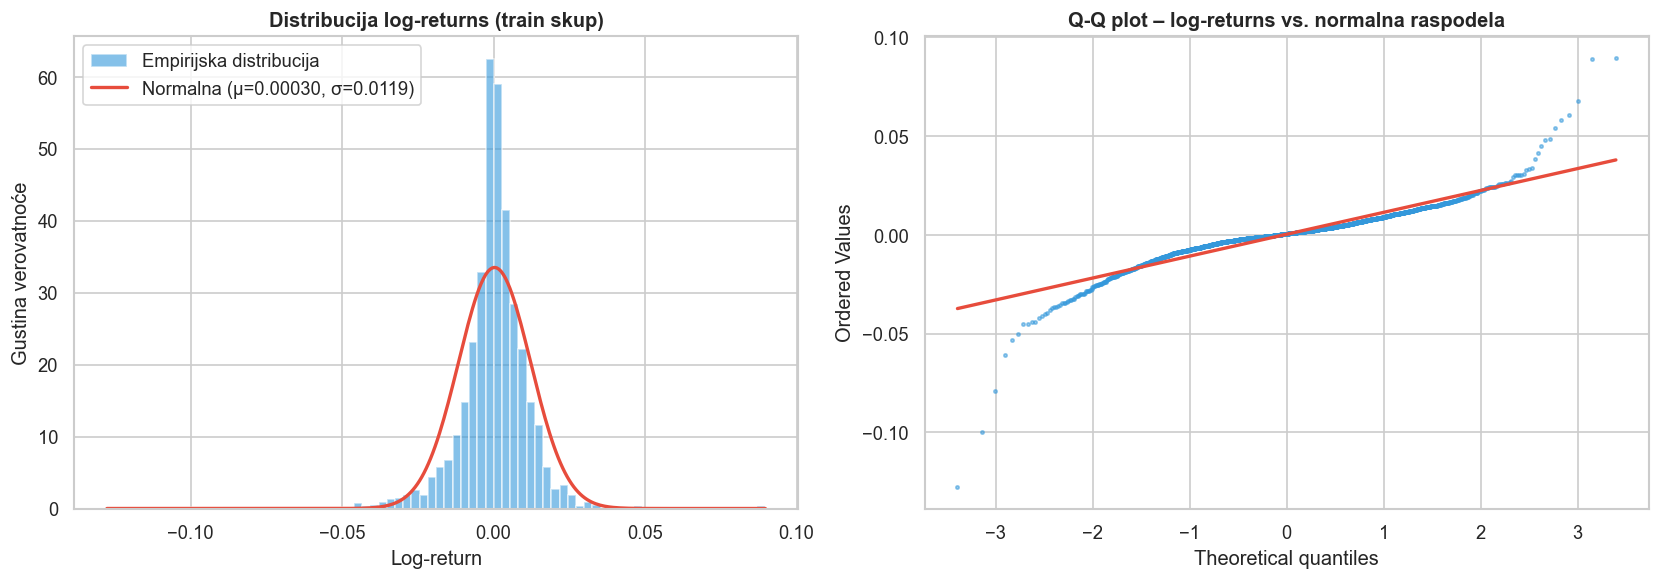

Jarque-Bera test normalnosti:
  JB statistika = 20339.80
  p-vrednost    = 0.00e+00
  Zaključak: distribucija log-returns NIJE normalna (α = 0.05)


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

lr = train['log_return']
mu, sigma = lr.mean(), lr.std()

# ── Levo: histogram + normalna kriva ─────────────────────────────────
axes[0].hist(lr, bins=80, density=True,
             color='#3498db', alpha=0.6, label='Empirijska distribucija')
x = np.linspace(lr.min(), lr.max(), 300)
axes[0].plot(x, scipy_stats.norm.pdf(x, mu, sigma),
             color='#e74c3c', linewidth=2,
             label=f'Normalna (μ={mu:.5f}, σ={sigma:.4f})')
axes[0].set_title('Distribucija log-returns (train skup)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Log-return')
axes[0].set_ylabel('Gustina verovatnoće')
axes[0].legend()

# ── Desno: Q-Q plot ───────────────────────────────────────────────────
scipy_stats.probplot(lr, dist='norm', plot=axes[1])
axes[1].set_title('Q-Q plot – log-returns vs. normalna raspodela', fontsize=12, fontweight='bold')
axes[1].get_lines()[0].set(color='#3498db', markersize=2, alpha=0.5)
axes[1].get_lines()[1].set(color='#e74c3c', linewidth=2)

plt.tight_layout()
plt.show()

jb_stat, jb_p = scipy_stats.jarque_bera(lr)
print(f'Jarque-Bera test normalnosti:')
print(f'  JB statistika = {jb_stat:.2f}')
print(f'  p-vrednost    = {jb_p:.2e}')
print(f'  Zaključak: distribucija log-returns {"NIJE" if jb_p < 0.05 else "jeste"} normalna (α = 0.05)')

**Interpretacija:** Na histogramu se vidi da je vrh empirijske distribucije viši i uži od normalne krive, a Q-Q plot jasno pokazuje odstupanje na oba repa – tačke skaču iznad linije za pozitivne ekstreme i ispod nje za negativne. Jarque-Bera test formalno potvrđuje da distribucija log-returns nije normalna. Ova osobina – **leptokurtičnost** – tipična je za finansijske serije i znači da modeli koji pretpostavljaju normalnost mogu da potcene verovatnoću ekstremnih događaja koji su kod ovakvih serija prisutni.

### 2.5 Pokretna srednja vrednost i volatilnost

Da bismo bolje videli dinamiku serije, računamo **pokretnu standardnu devijaciju** na prozoru od 30 trading dana. Ovo je jednostavna empirijska mera volatilnosti – pokazuje koliko su oscilacije bile velike u svakom 30-dnevnom periodu, bez ikakvog modela.

Ako volatilnost nije ravnomerno raspoređena kroz vreme već se grupiše u specifičnim periodima, radi se o **volatility clustering**-u – i upravo to GARCH modeluje.

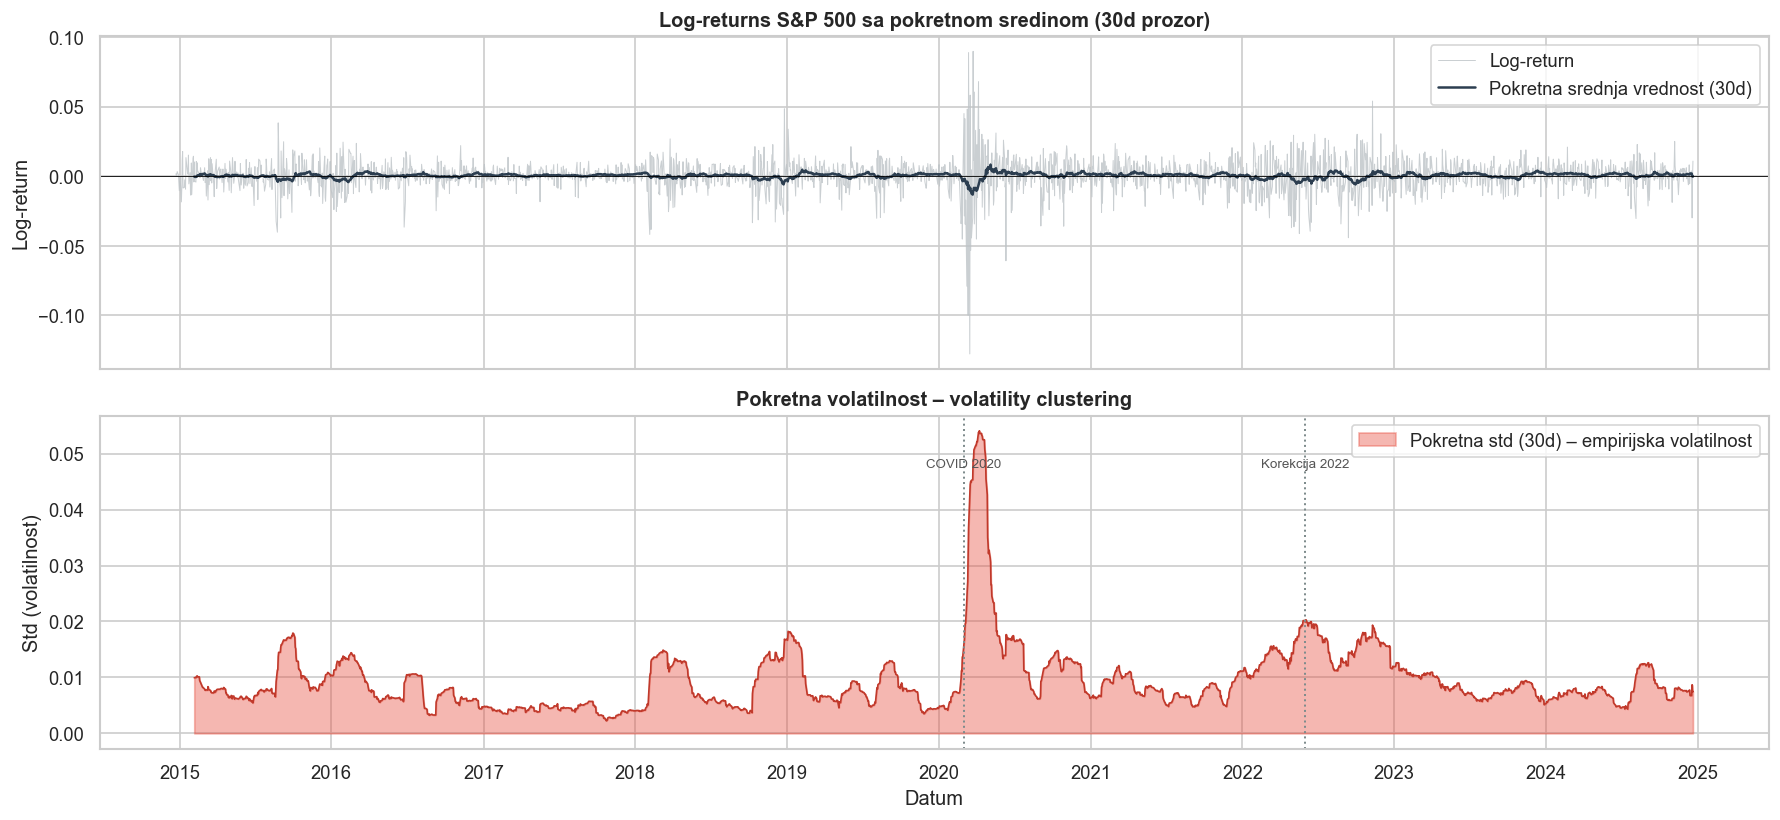

In [10]:
window = 30  # širina posmatranog prozora k=30

rolling_mean = full_df['log_return'].rolling(window).mean()
rolling_std  = full_df['log_return'].rolling(window).std()

fig, axes = plt.subplots(2, 1, figsize=(15, 7), sharex=True)

# ── Gornji: log-returns + pokretna sredina ────────────────────────────
axes[0].plot(full_df.index, full_df['log_return'],
             color='#bdc3c7', linewidth=0.6, alpha=0.8, label='Log-return')
axes[0].plot(rolling_mean.index, rolling_mean,
             color='#2c3e50', linewidth=1.5,
             label=f'Pokretna srednja vrednost ({window}d)')
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].set_ylabel('Log-return')
axes[0].set_title(f'Log-returns S&P 500 sa pokretnom sredinom ({window}d prozor)',
                   fontsize=12, fontweight='bold')
axes[0].legend()

# ── Donji: pokretna volatilnost ───────────────────────────────────────
axes[1].fill_between(rolling_std.index, rolling_std,
                     color='#e74c3c', alpha=0.4,
                     label=f'Pokretna std ({window}d) – empirijska volatilnost')
axes[1].plot(rolling_std.index, rolling_std, color='#c0392b', linewidth=1.0)

for datum, tekst in [
    ('2020-03-01', 'COVID 2020'),
    ('2022-06-01', 'Korekcija 2022'),
]:
    axes[1].axvline(pd.Timestamp(datum), color='#7f8c8d', linestyle=':', linewidth=1.2)
    axes[1].text(pd.Timestamp(datum), rolling_std.max() * 0.88,
                 tekst, fontsize=8, ha='center', color='#555')

axes[1].set_ylabel('Std (volatilnost)')
axes[1].set_xlabel('Datum')
axes[1].set_title('Pokretna volatilnost – volatility clustering',
                   fontsize=12, fontweight='bold')
axes[1].legend()

axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[1].xaxis.set_major_locator(mdates.YearLocator())
plt.tight_layout()
plt.show()

**Interpretacija:** Volatilnost nije konstantna – za vreme COVID krize i tokom 2022. standardna devijacija je višestruko veća nego u mirnim periodima. Vidljivo je i da se visoka volatilnost ne smiruje odmah, već traje neko vreme pre nego što se vrati na niske vrednosti, što takođe opravdava primenu GARCH modela.

### 2.6 STL dekompozicija

Primenjujem **STL dekompoziciju** (Seasonal-Trend decomposition using LOESS) da bih formalno razdvojio seriju na komponente: trend, sezonalnost i reziduale.

Za period sezonalnosti uzimam **252 trading dana** što odgovara jednoj berzanskoj godini. Pošto su log-returns već transformisana serija, očekujem da trend i sezonalnost budu mali u poređenju sa rezidualnim šumom – što bi potvrdilo da je serija dominantno nepredvidiva i da je predikcija tačne vrednosti log-returns prilično nepouzdana i teška.

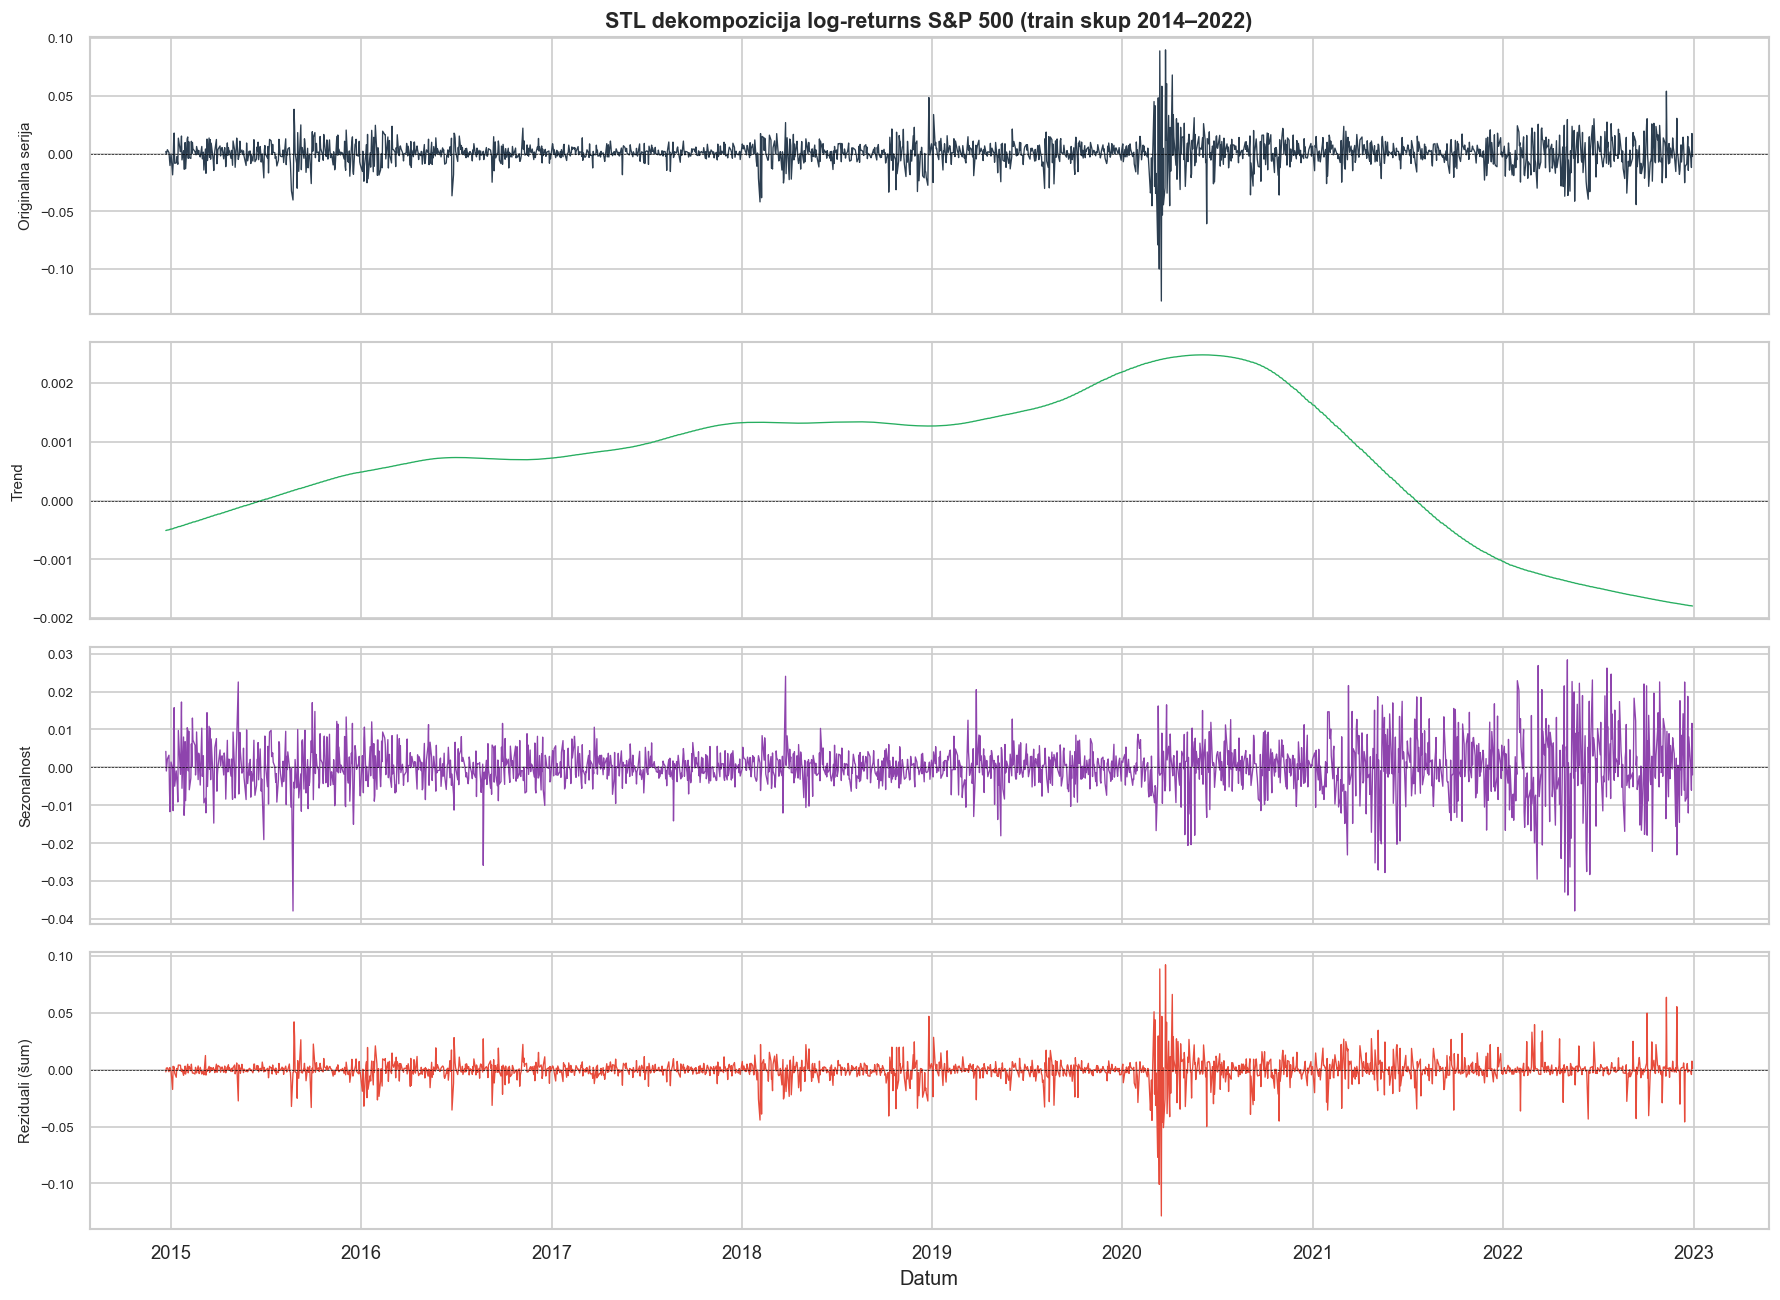

=== Udeo varijanse po komponentama ===
  Trend          : 0.90%
  Sezonalnost    : 31.65%
  Reziduali      : 84.34%


In [11]:
from statsmodels.tsa.seasonal import STL

stl = STL(train['log_return'], period=252, robust=True)
result = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(15, 11), sharex=True)

komponente = [
    (train['log_return'], 'Originalna serija', '#2c3e50'),
    (result.trend,        'Trend',             '#27ae60'),
    (result.seasonal,     'Sezonalnost',       '#8e44ad'),
    (result.resid,        'Reziduali (šum)',   '#e74c3c'),
]

for ax, (data, naziv, boja) in zip(axes, komponente):
    ax.plot(data.index, data.values, color=boja, linewidth=0.8)
    ax.axhline(0, color='black', linewidth=0.4, linestyle='--')
    ax.set_ylabel(naziv, fontsize=9)
    ax.tick_params(axis='y', labelsize=8)

axes[0].set_title('STL dekompozicija log-returns S&P 500 (train skup 2014–2022)',
                   fontsize=13, fontweight='bold')
axes[-1].set_xlabel('Datum')
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
plt.tight_layout()
plt.show()

var_total = train['log_return'].var()
print('=== Udeo varijanse po komponentama ===')
for naziv, vrednost in [
    ('Trend',       result.trend.var()),
    ('Sezonalnost', result.seasonal.var()),
    ('Reziduali',   result.resid.var()),
]:
    print(f'  {naziv:<15}: {100 * vrednost / var_total:.2f}%')

**Interpretacija:** Ako reziduali čine više od 90-95% ukupne varijanse (što je tipično za log-returns finansijskih indeksa), trend i sezonalnost su minimalni – serija je u suštini dominantno šum. Ovo je konzistentno sa hipotezom o efikasnom tržištu i potvrđuje da modeli poput ARIMA ne mogu da daju visoku tačnost predikcije vrednosti.

Ipak, to ne znači da modelovanje nema smisla. ARIMA i Prophet koristim da ispitam da li postoji autokorelaciona struktura u seriji, dok GARCH modeluje **dinamiku volatilnosti**.

---
## 3. Testiranje stacionarnosti

Na osnovu vizualne analize iz prethodne sekcije, log-returns deluju stacionarno – nema vidljivog trenda ni promena u širini oscilacija (izuzev kriznih perioda). Međutim, pre primene bilo kog modela ovo mora biti **formalno potvrđeno** statističkim testom.

Za testiranje stacionarnosti koristim **ADF test** (Augmented Dickey-Fuller). Nulta hipoteza ovog testa je da serija **nije stacionarna**. Ako je p-vrednost ≤ 0.05, odbacujemo nultu hipotezu i zaključujemo da je serija stacionarna sa 95% pouzdanosti.

Testiramo obe verzije serije – originalne vrednosti S&P 500 i log-returns

In [12]:
from src.stationarity import adf_test, print_adf_result, plot_acf_pacf, suggest_arima_params, white_noise_summary, compare_adf

### 3.1 ADF test – originalne vrednosti indeksa (sirove cene)

Prvo testiramo nad originalnim cenama. Pošto smo videli jasan rastući trend, očekujemo da serija neće biti stacionarna – ADF test bi trebalo to da potvrdi.

In [13]:
adf_cene = adf_test(train['S&P500'], naziv='S&P 500 – sirove cene (train)')
print_adf_result(adf_cene)

──────────────────────────────────────────────────
  ADF test: S&P 500 – sirove cene (train)
──────────────────────────────────────────────────
  ADF statistika   : -0.97
  p-vrednost       : 0.764064
  Broj lagova      : 10
  Broj opservacija : 2009
  Kritične vrednosti:
    1%  : -3.4336
    5%  : -2.863
    10% : -2.5675
  Zaključak: NIJE STACIONARNA
──────────────────────────────────────────────────



**Interpretacija:** Sirove cene **nisu stacionarne** – p-vrednost je daleko iznad 0.05, a ADF statistika nije dovoljno negativna da bi prešla kritičnu vrednost. Ovo znači da statistički karakter serije (srednja vrednost, varijansa) nije konstantan kroz vreme, što onemogućava direktnu primenu AR/MA/ARIMA modela.

### 3.2 ADF test – log-returns

Sada testiramo log-returns. Ovo je serija sa kojom zapravo radimo, i potrebno je ADF test prođe pre nego što započnemo modelovanje.

In [14]:
adf_returns = adf_test(train['log_return'], naziv='S&P 500 – log-returns (train)')
print_adf_result(adf_returns)

──────────────────────────────────────────────────
  ADF test: S&P 500 – log-returns (train)
──────────────────────────────────────────────────
  ADF statistika   : -14.0562
  p-vrednost       : 0.0
  Broj lagova      : 9
  Broj opservacija : 2010
  Kritične vrednosti:
    1%  : -3.4336
    5%  : -2.863
    10% : -2.5675
  Zaključak: STACIONARNA (99%)
──────────────────────────────────────────────────



**Interpretacija:** Log-returns su **stacionarni** – p-vrednost je znatno ispod 0.05, a ADF statistika je negativnija od kritične vrednosti na nivou 1%. Ovo formalno potvrđuje ono što smo videli vizuelno i odobrava primenu ARIMA modela.

---
### 3.3 ACF i PACF analiza

Pošto smo potvrdili stacionarnost, sledeći korak je analiza **autokorelacione strukture** serije. Koristimo dva grafika:

**ACF (autokorelogram)** prikazuje korelaciju serije sa samom sobom pomerenom za k koraka unazad. Ako je vrednost za lag k izvan osenčenog pojasa, ta korelacija je statistički značajna. Obrazac koji tražimo:
- Nagli pad posle q lagova → indikator za MA(q) komponentu
- Postepen pad → indikator za AR komponentu

**PACF (parcijalni autokorelogram)** prikazuje samo **direktan** uticaj prošle vrednosti na sadašnju, eliminišući posredne uticaje. Na primer, ako januar utiče na februar, a februar na mart, PACF za mart neće prikazivati uticaj januara kao značajan (jer je on posredan, ide kroz februar). Obrazac koji tražimo:
- Nagli pad posle p lagova → indikator za AR(p) komponentu
- Postepen pad → indikator za MA komponentu

Osenčen pojas na oba grafika predstavlja vrednosti koje bismo sa 95% verovatnoće dobili za šum (white noise). Sve vrednosti izvan tog pojasa su statistički značajne.

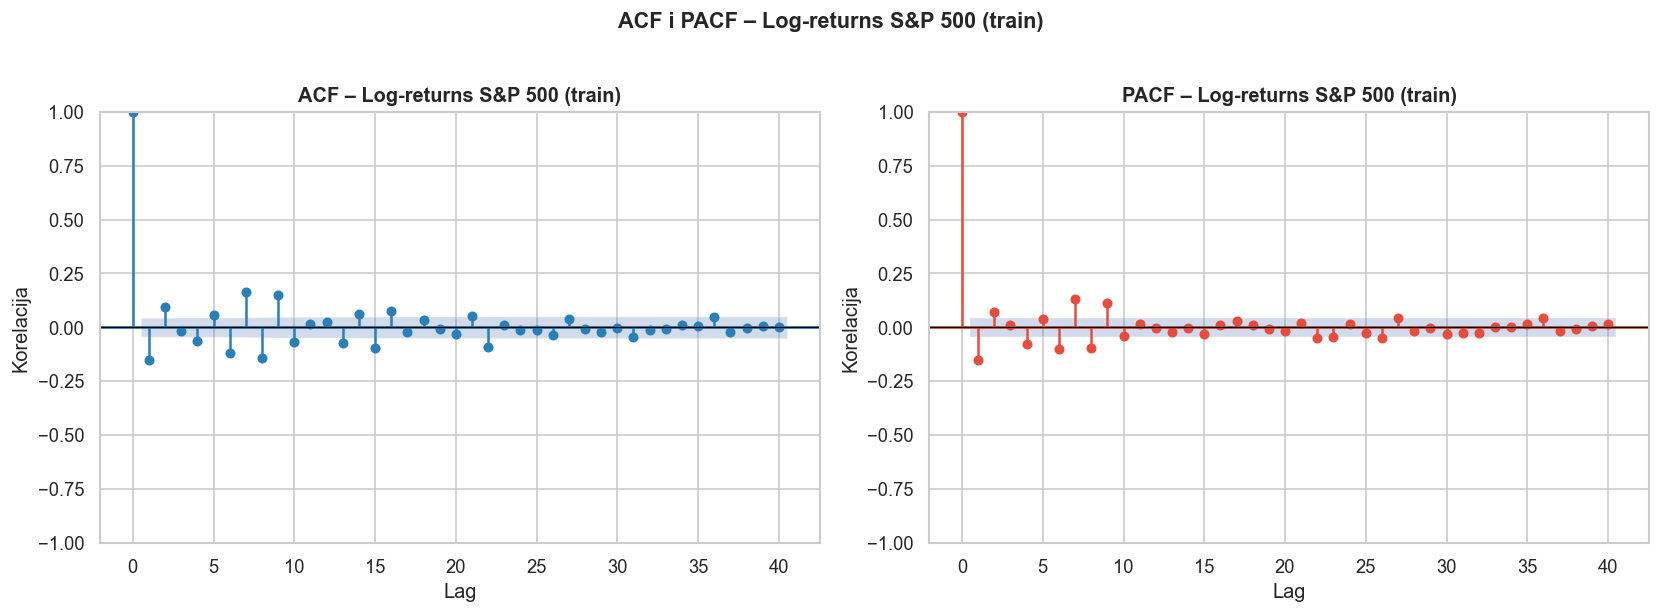

In [15]:
plot_acf_pacf(
    series = train['log_return'],
    lags   = 40,
    naziv  = 'Log-returns S&P 500 (train)'
)

**Interpretacija ACF i PACF grafika:**

ACF i PACF grafici log-prinosa pokazuju prisustvo više statistički značajnih autokorelacionih koeficijenata, posebno za niže lag-ove (1-10). Postoje vrednosti izvan osenčenog dela što ukazuje da serija nije idealan šum u strogo statističkom smislu.

Iako su pojedini lag-ovi statistički značajni, njihove apsolutne vrednosti su relativno male. Ovim potvrđujemo postojanje slabe kratkoročne linearne zavisnosti što je karakteristično za finansijske i indeks serije.

Zaključak :
- Serija nije savršeni beli šum
- Postoji slaba (kratkoročna) linearna zavisnost
- Odsustvo dugoročne autokorelacione strukture

### 3.3.1 Formalna potvrda belog šuma

Vizuelna analiza ACF/PACF grafika nije dovoljna. Zaključak iz sekcije 3.3 potrebno je potvrditi i statističkim testom. Koristimo dva komplementarna formalna testa:

- **Ljung-Box test** – H0: nema linearne autokorelacije (testira se na više lagova: log(N) (7, 10, 20, 30)
- **Runs test** (Wald-Wolfowitz) – neparametarski test opšte slučajnosti

Oba testa vršimo isključivo na **trening skupu**

In [16]:
log_returns = train['log_return']
white_noise_summary(log_returns, naziv="S&P 500 dnevni log-prinosi") # LB test belog šuma i Runs test slučajnosti(da li su promene znaka +/- slučajne)


════════════════════════════════════════════════════════════
  ANALIZA BELOG ŠUMA: S&P 500 dnevni log-prinosi
════════════════════════════════════════════════════════════

────────────────────────────────────────────────────────────
  Ljung-Box test belog šuma – S&P 500 dnevni log-prinosi
────────────────────────────────────────────────────────────
  H0: serija je beli šum (nema linearne autokorelacije)
  N  = 2020 opservacija

       lb_stat     lb_pvalue
7   165.304905  2.450378e-32
10  262.565442  1.231942e-50
20  321.608940  3.056837e-56
30  353.055029  7.685965e-57

  Zaključak: ODBACUJEMO H0 → postoji statistički značajna linearna autokorelacija
────────────────────────────────────────────────────────────

────────────────────────────────────────────────────────────
  Runs test slučajnosti – S&P 500 dnevni log-prinosi
────────────────────────────────────────────────────────────
  N ukupno       : 2020
  N pozitivnih   : 1010
  N negativnih   : 1010
  Broj runs-ova  : 1052  (oček

### 3.4 Okvirna preporuka parametara na osnovu ACF/PACF

In [17]:
preporuka = suggest_arima_params(train['log_return'], lags=40)

print('=== Okvirna preporuka parametara (ACF/PACF heuristika) ===')
print(f"  p (AR red) : {preporuka['p']}")
print(f"  d (dif red) : {preporuka['d']}")
print(f"  q (MA red) : {preporuka['q']}")
print(f"  Napomena   : {preporuka['napomena']}")

=== Okvirna preporuka parametara (ACF/PACF heuristika) ===
  p (AR red) : 27
  d (dif red) : 0
  q (MA red) : 36
  Napomena   : Heuristika – koristiti zajedno sa auto_arima i AIC/BIC.


---
### Zaključak sekcije 3

- ADF test formalno je potvrdio da su **sirove cene nestacionarne**, a **log-returns stacionarni** – parametar d u ARIMA modelu biće 0
- ACF i PACF analiza dala je okvirne vrednosti za parametre p i q
- Ovu ručnu procenu koristimo kao polaznu tačku, a pomoću auto_arima vršimo sistematičnu pretragu kombinacija parametara i biramo optimalnu na osnovu AIC kriterijuma

**Sledeći korak:** Parametri ARIMA modela (`src/arima_model.py`)

---
## 4. ARIMA model

**ARIMA (AutoRegressive Integrated Moving Average)** kombinuje tri komponente:

- **AR(p)** – autoregresivna komponenta: trenutna vrednost je linearna kombinacija prethodnih p vrednosti serije
- **I(d)** – diferenciranje reda d: koliko puta diferenciramo seriju da bi postala stacionarna
- **MA(q)** – komponenta pokretnog proseka grešaka: trenutna vrednost zavisi od prethodnih q grešaka modela

Pošto smo u sekciji 3 potvrdili da su log-returns već stacionarni, parametar **d=0** i efektivno radimo sa ARMA(p,q) modelom.

### Važna napomena o očekivanjima

Log-returns pokazuju prisustvo statistički značajne, ali slabe i kratkoročne linearne autokorelacije, što je potvrđeno u sekciji 3. Zbog toga očekujemo da ARIMA model pokaže ograničenu moć u smislu predikcije (što nije posledica lošeg modelovanja, već prirode finansijskih prinosa). U tom kontekstu cilj ARIMA modela u ovom projektu je :

1. Formalno ispitati postoji li i kakva prediktivna struktura u seriji
2. Generisati rezidualne greške koje prosleđujemo GARCH modelu za modelovanje volatilnosti

In [18]:
from src.arima_model import (
    auto_arima_search,
    fit_arima,
    walk_forward_predict,
    dijagnostika_reziduala,
    plot_arima_predictions,
    plot_arima_residuals,
    get_reziduali_za_garch,
    grid_search_arima
)
from src.evaluation import (
    compute_all_metrics,
    interpret_log_returns,
    plot_price_interpretation
)

### 4.1 Pretraga optimalnih parametara – auto_arima

Koristimo `auto_arima` iz biblioteke `pmdarima` da sistematično pretražimo kombinacije parametara (p, d, q) i odaberemo onu sa najnižim **AIC** (Akaike Information Criterion).

**AIC** meri balans između tačnosti modela i njegove kompleksnosti – kompleksniji model (više parametara) se kažnjava. Niži AIC = bolji model. Koristimo AIC umesto BIC jer AIC favorizuje malo kompleksnije modele što je za predikciju obično bolje.

In [19]:
auto_result = auto_arima_search(
    series  = train['log_return'],
    max_p   = 5,
    max_q   = 5,
    max_d   = 1,
    ic      = 'aic',
    verbose = True,
)

optimalni_order = auto_result['order']
print(f"AUTO-ARIMA parametri: {optimalni_order}")

Pokrećem auto_arima (kriterijum: AIC, max_p=5, max_q=5)...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-12163.707, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-12209.751, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-12202.770, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-12218.183, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-12216.346, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-12216.023, Time=0.52 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-12212.699, Time=0.25 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-12214.217, Time=0.66 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-12217.742, Time=0.57 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 2.949 seconds

Optimalni model: ARIMA(2,0,0)
  AIC: -12218.1828
  BIC: -12201.3502
AUTO-ARIMA parametri: (2, 0, 0)


### 4.1.1 Grid search kombinacija p i q

Umesto da se oslanjamo isključivo na `auto_arima`, eksplicitno prolazimo kroz sve kombinacije p ∈ [0,4], q ∈ [0,4] uz d=0 (potvrđeno ADF testom). Tabela sortirana po AIC prikazuje i Ljung-Box p-vrednost na rezidualima.

**Kako čitati tabelu:**
- `LB_p(10)` > 0.05 → reziduali su beli šum 
- Ako su AIC vrednosti više modela bliske (razlika < 2), biramo onaj sa manjim p+q (**manja dimenzionalnost modela**)

In [20]:
tabela = grid_search_arima(log_returns, max_p=4, max_q=4, d=0, ic='aic')

display(tabela.head(10))

grid_best_order = (int(tabela.iloc[0]['p']), 0, int(tabela.iloc[0]['q']))

print(f'Grid search predlog : ARIMA{grid_best_order}')
print(f'auto_arima predlog : ARIMA{optimalni_order}')
print()

Grid search ARIMA(p,0,q) za p∈[0,4], q∈[0,4]...
Kriterijum odabira: AIC

Top 10 modela po AIC:
 p  d  q       AIC       BIC  LB_p(10)
 3  0  2 -12275.92 -12236.65       0.0
 3  0  4 -12248.45 -12197.95       0.0
 4  0  3 -12242.48 -12191.98       0.0
 4  0  0 -12225.65 -12191.99       0.0
 4  0  1 -12222.95 -12183.67       0.0
 0  0  4 -12220.82 -12187.15       0.0
 4  0  2 -12219.87 -12174.98       0.0
 1  0  4 -12219.23 -12179.95       0.0
 0  0  3 -12218.81 -12190.76       0.0
 0  0  2 -12217.96 -12195.52       0.0

→ Optimalni po AIC: ARIMA(3,0,2)
  AIC=-12275.92, BIC=-12236.65
  Napomena: ako je LB_p(10) < 0.05, reziduali NISU beli šum.


p  d  q       AIC       BIC  LB_p(10)
0  3  0  2 -12275.92 -12236.65       0.0
1  3  0  4 -12248.45 -12197.95       0.0
2  4  0  3 -12242.48 -12191.98       0.0
3  4  0  0 -12225.65 -12191.99       0.0
4  4  0  1 -12222.95 -12183.67       0.0
5  0  0  4 -12220.82 -12187.15       0.0
6  4  0  2 -12219.87 -12174.98       0.0
7  1  0  4 -12219.23 -12179.95       0.0
8  0  0  3 -12218.81 -12190.76       0.0
9  0  0  2 -12217.96 -12195.52       0.0

Grid search predlog : ARIMA(3, 0, 2)
auto_arima predlog : ARIMA(2, 0, 0)



In [21]:
# LB_p = 0.0 za sve modele sugeriše ARCH efekat
# Za finalni odabir koristimo AIC i minimizujemo p+q

tabela['p+q'] = tabela['p'] + tabela['q']
delta_aic = tabela['AIC'] - tabela['AIC'].min()

# Modeli u AIC±2 opsegu od najboljeg
kandidati = tabela[delta_aic <= 2].copy()
print("Kandidati u AIC ±2 opsegu od najboljeg:")
display(kandidati)

# Minimizujemo p+q
finalni_izbor = kandidati.sort_values('p+q').iloc[0]
finalni_order = (int(finalni_izbor['p']), 0, int(finalni_izbor['q']))

print(f"\nFinalni odabir po složenosti parametara: ARIMA{finalni_order}")
print(f"  AIC = {finalni_izbor['AIC']}")
print(f"  p+q = {int(finalni_izbor['p+q'])} (složenost modela)")
print()
print("Prisutan ARCH efekat (volatility clustering) koji ARIMA")
print("ne modeluje. Ovo opravdava primenu GARCH modela u narednoj fazi.")

Kandidati u AIC ±2 opsegu od najboljeg:


p  d  q       AIC       BIC  LB_p(10)  p+q
0  3  0  2 -12275.92 -12236.65       0.0    5


Finalni odabir po složenosti parametara: ARIMA(3, 0, 2)
  AIC = -12275.92
  p+q = 5 (složenost modela)

Prisutan ARCH efekat (volatility clustering) koji ARIMA
ne modeluje. Ovo opravdava primenu GARCH modela u narednoj fazi.


### 4.2 Treniranje modela

Treniramo ARIMA model na trening skupu sa odabranim parametrima.

In [22]:
arima_fitted = fit_arima(
    series = train['log_return'],
    order  = finalni_order,
)

print(arima_fitted.summary())

Treniram ARIMA(3,0,2) na 2020 opservacija...
  AIC: -12275.9228
  BIC: -12236.6468
                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 2020
Model:                 ARIMA(3, 0, 2)   Log Likelihood                6144.961
Date:                Fri, 27 Feb 2026   AIC                         -12275.923
Time:                        23:06:43   BIC                         -12236.647
Sample:                             0   HQIC                        -12261.509
                               - 2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.543      0.123      -0.000       0.001
ar.L1         -1.3297      0.048    -27.608     

**Tumačenje:**

- **Koeficijenti (coef)** – vrednosti AR i MA parametara; ako im je p-vrednost (P>|z|) veća od 0.05, taj parametar nije statistički značajan
- **AIC / BIC** – što niži, to bolje; koristiće nam za poređenje sa Prophet modelom
- **Ljung-Box test (Q)** – ako je p-vrednost > 0.05, reziduali ne pokazuju autokorelaciju što znači da je model dobro uhvatio strukturu serije

### 4.3 Walk-forward validacija na validacionom skupu

Pre nego što pokrenemo evaluaciju na test skupu, testiraćemo model na **validacionom skupu** (2023. godina).

Walk-forward validacija : svaki dan predviđamo vrednost za sledeći dan, a zatim pravu vrednost unosimo u istoriju pre sledeće predikcije.

In [23]:
# Validaciona evaluacija
arima_val_rezultati = walk_forward_predict(
    train = train['log_return'],
    test  = val['log_return'],
    order = finalni_order,
)

# Metrike na validacionom skupu
arima_val_metrike = compute_all_metrics(
    y_true     = arima_val_rezultati['y_true'].values,
    y_pred     = arima_val_rezultati['y_pred'].values,
    y_train    = train['log_return'].values,
    model_name = f'ARIMA{finalni_order} – Validation'
)

display(arima_val_metrike)

Walk-forward validacija – ARIMA(3,0,2), 250 predikcija
  50/250 predikcija završeno...
  100/250 predikcija završeno...
  150/250 predikcija završeno...
  200/250 predikcija završeno...
  250/250 predikcija završeno...
  Walk-forward validacija završena.


Model       MAE      RMSE    MASE
0  ARIMA(3, 0, 2) – Validation  0.006716  0.008487  0.5979

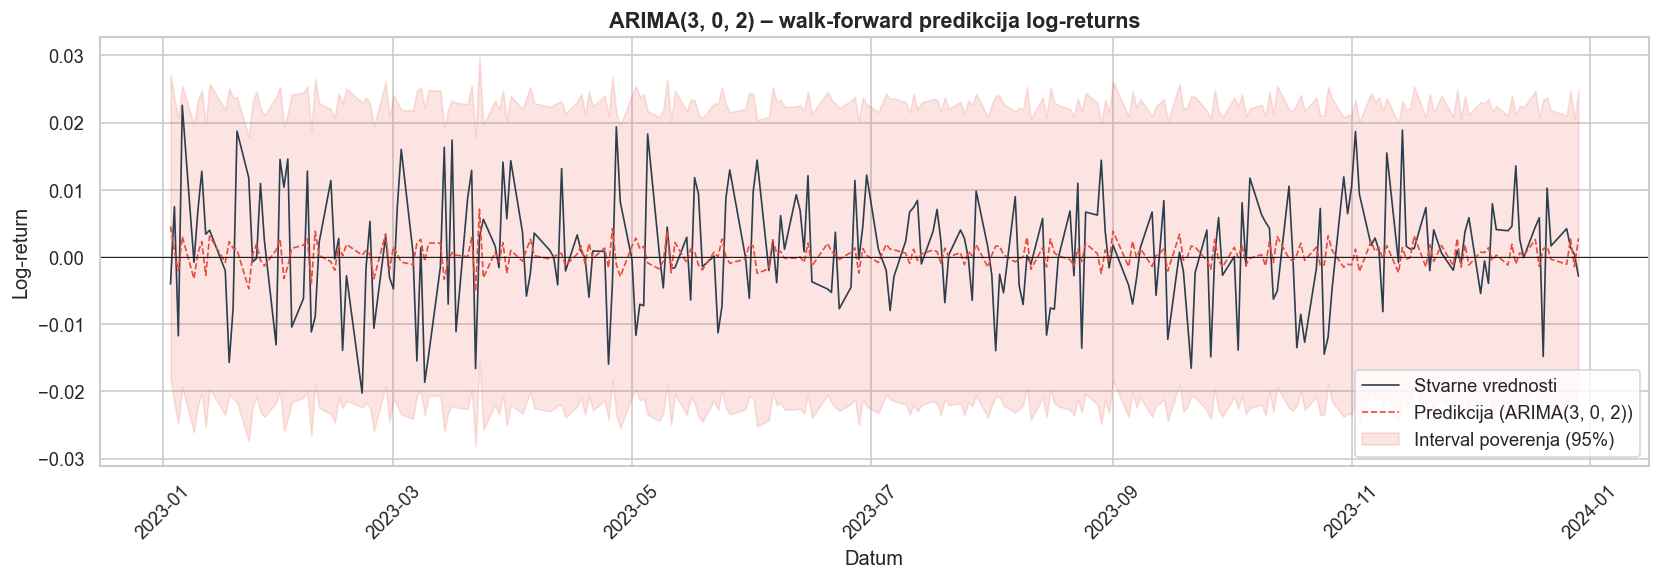

In [ ]:
plot_arima_predictions(
    rezultati  = arima_val_rezultati,
    model_name = f'ARIMA{finalni_order}',
)

### 4.4 Finalna evaluacija na test skupu

Sada pokrećem evaluaciju na **test skupu** (2024. godina). Rezultate koristimo za finalno poređenje modela.

In [25]:
# Proširujemo trening skup sa validacionim pre finalne evaluacije
train_full = pd.concat([train['log_return'], val['log_return']])

arima_test_rezultati = walk_forward_predict(
    train = train_full,
    test  = test['log_return'],
    order = finalni_order,
)

arima_test_metrike = compute_all_metrics(
    y_true     = arima_test_rezultati['y_true'].values,
    y_pred     = arima_test_rezultati['y_pred'].values,
    y_train    = train_full.values,
    model_name = f'ARIMA{finalni_order} – Test'
)

display(arima_test_metrike)

Walk-forward validacija – ARIMA(3,0,2), 246 predikcija
  50/246 predikcija završeno...
  100/246 predikcija završeno...
  150/246 predikcija završeno...
  200/246 predikcija završeno...
  Walk-forward validacija završena.


Model       MAE      RMSE    MASE
0  ARIMA(3, 0, 2) – Test  0.005994  0.008131  0.5448

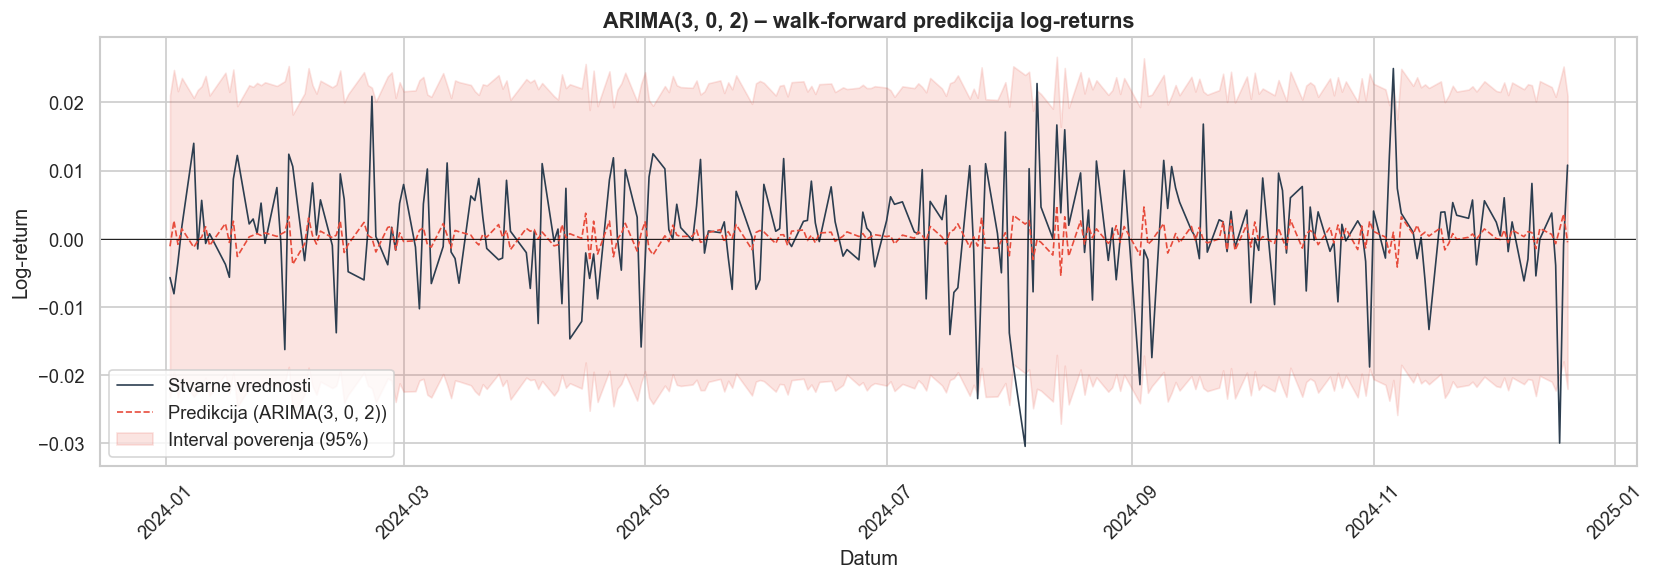

In [26]:
plot_arima_predictions(
    rezultati  = arima_test_rezultati,
    model_name = f'ARIMA{finalni_order}',
)

### 4.4.1 Interpretabilnost predikcija – povratak na vrednost indeksa

**Log-returns** su matematički pogodni za modelovanje, ali nisu intuitivni za interpretaciju. Stoga, potrebno ih je konvertovati nazad na cenu indeksa koristeći eksponencijalnu transformaciju :

$$P_t = P_0 \cdot e^{\sum_{i=1}^{t} r_i}$$

gde je $P_0$ poslednja poznata cena pre test perioda. Gornji grafik prikazuje kretanje cene, donji log-returns – zajedno daju potpunu sliku tačnosti modela.

Polazna cena za rekonstrukciju: 4769.83


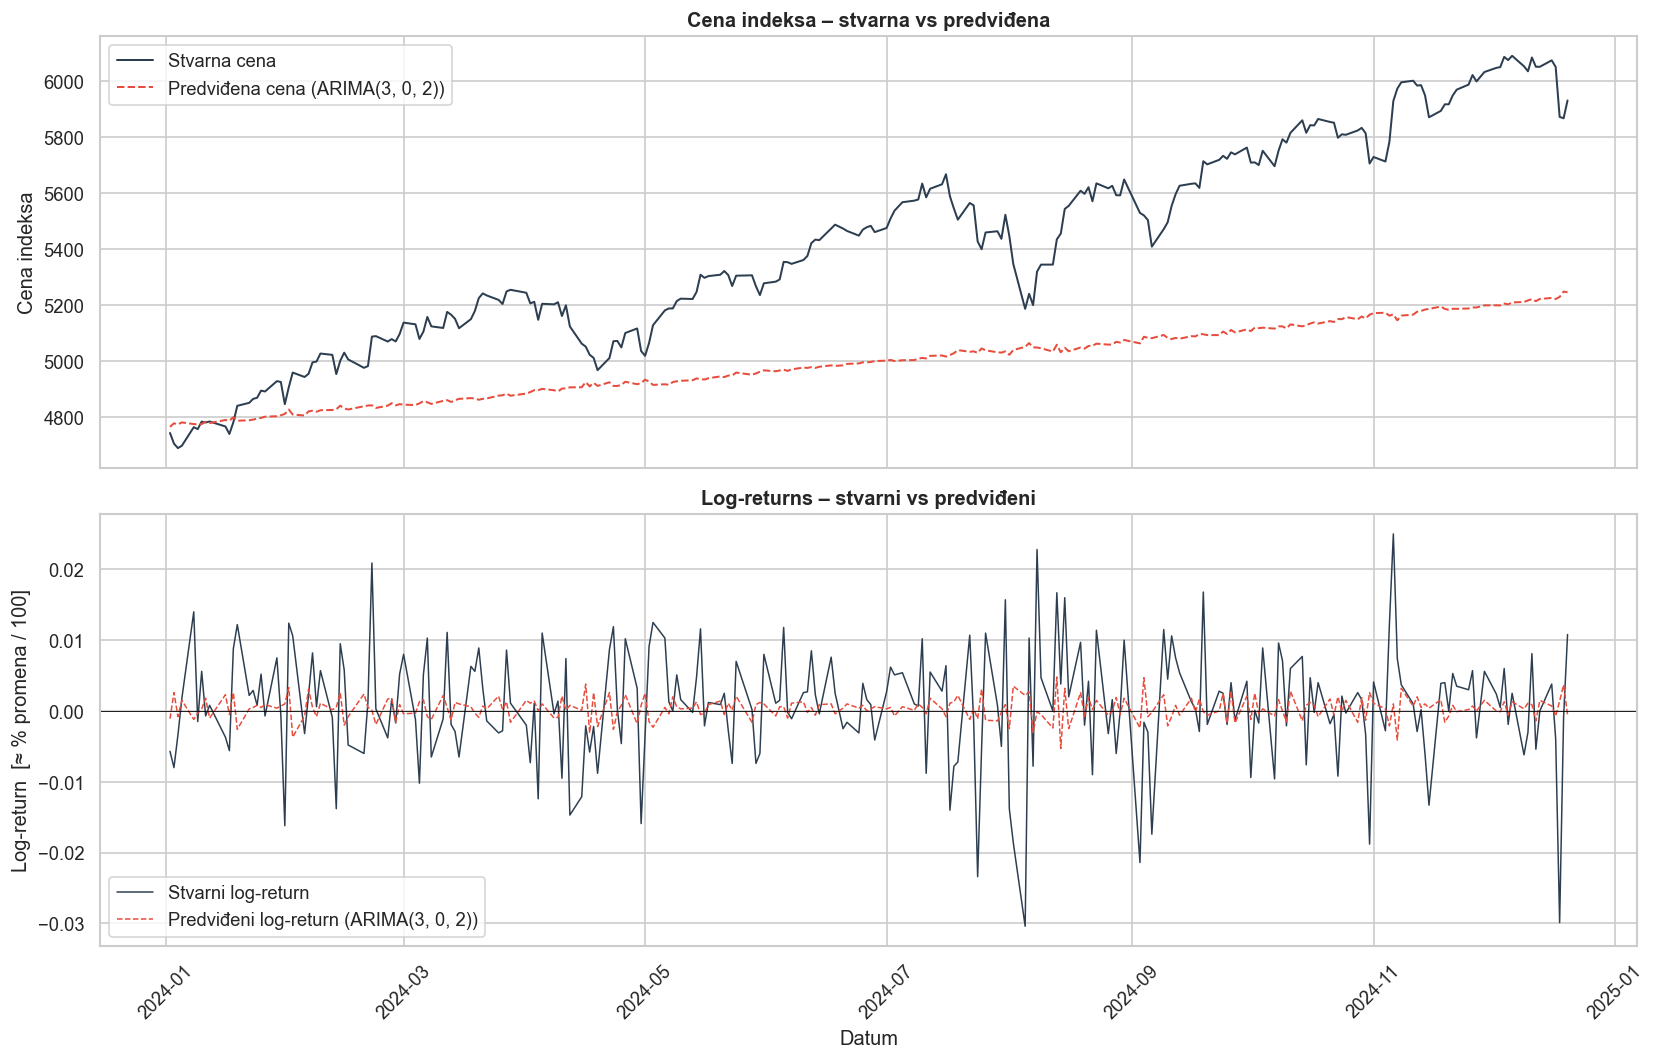

Napomena o interpretaciji log-returns:
  log_return_t = ln(P_t / P_{t-1})
  Za male vrednosti: log_return ≈ procentualna promena / 100
  Primer: log_return = 0.012 → cena porasla ~1.2%
  Primer: log_return = -0.020 → cena pala ~2.0%

  Opseg predviđenih log-returns: [-0.0053, 0.0048]
  Prosečna apsolutna greška u ceni: 7.56%

Prvih 10 dana predikcije:


log_return_predviđen  prosta_stopa_pred_%  cena_predviđena  \
2024-01-02               -0.0011              -0.1086        4764.6515   
2024-01-03                0.0026               0.2648        4777.2690   
2024-01-04               -0.0008              -0.0796        4773.4655   
2024-01-05                0.0015               0.1481        4780.5358   
2024-01-08               -0.0012              -0.1229        4774.6603   
2024-01-09               -0.0003              -0.0303        4773.2151   
2024-01-10                0.0003               0.0263        4774.4689   
2024-01-11                0.0018               0.1783        4782.9812   
2024-01-12               -0.0010              -0.0987        4778.2607   
2024-01-16                0.0023               0.2262        4789.0710   

            cena_stvarna  greška_cene  
2024-01-02       4742.83      21.8215  
2024-01-03       4704.81      72.4590  
2024-01-04       4688.68      84.7855  
2024-01-05       4697.24      83.2958  
2024-01-08       4763.54      11.1203  
2024-01-09       4756.50      16.7151  
2024-01-10       4783.45      -8.9811  
2024-01-11       4780.24       2.7412  
2024-01-12       4783.83      -5.5693  
2024-01-16       4765.98      23.0910

In [27]:
# Poslednja poznata cena indeksa pre test perioda
polazna_cena = val['S&P500'].iloc[-1]
print(f'Polazna cena za rekonstrukciju: {polazna_cena:.2f}')

df_interpret = interpret_log_returns(
    log_returns_true = arima_test_rezultati['y_true'],
    log_returns_pred = arima_test_rezultati['y_pred'],
    poslednja_cena   = polazna_cena,
    model_name       = f'ARIMA{finalni_order}',
)

plot_price_interpretation(df_interpret, model_name=f'ARIMA{finalni_order}')

# Pregled tabele: log-return → prosta stopa → cena
print('\nPrvih 10 dana predikcije:')
display(df_interpret[[
    'log_return_predviđen', 'prosta_stopa_pred_%',
    'cena_predviđena', 'cena_stvarna', 'greška_cene'
]].head(10))

### 4.5 Dijagnostika reziduala i priprema za GARCH

Analiziramo rezidualne greške ARIMA modela iz dva razloga:

1. **Provera kvaliteta modela** – ako reziduali sadrže autokorelaciju, model nije dobro uhvatio strukturu serije i parametri možda treba da se koriguju
2. **Provera ARCH efekta** – ako **kvadrirani** reziduali pokazuju autokorelaciju, to znači da postoji volatility clustering u greškama modela, što je direktna motivacija za GARCH

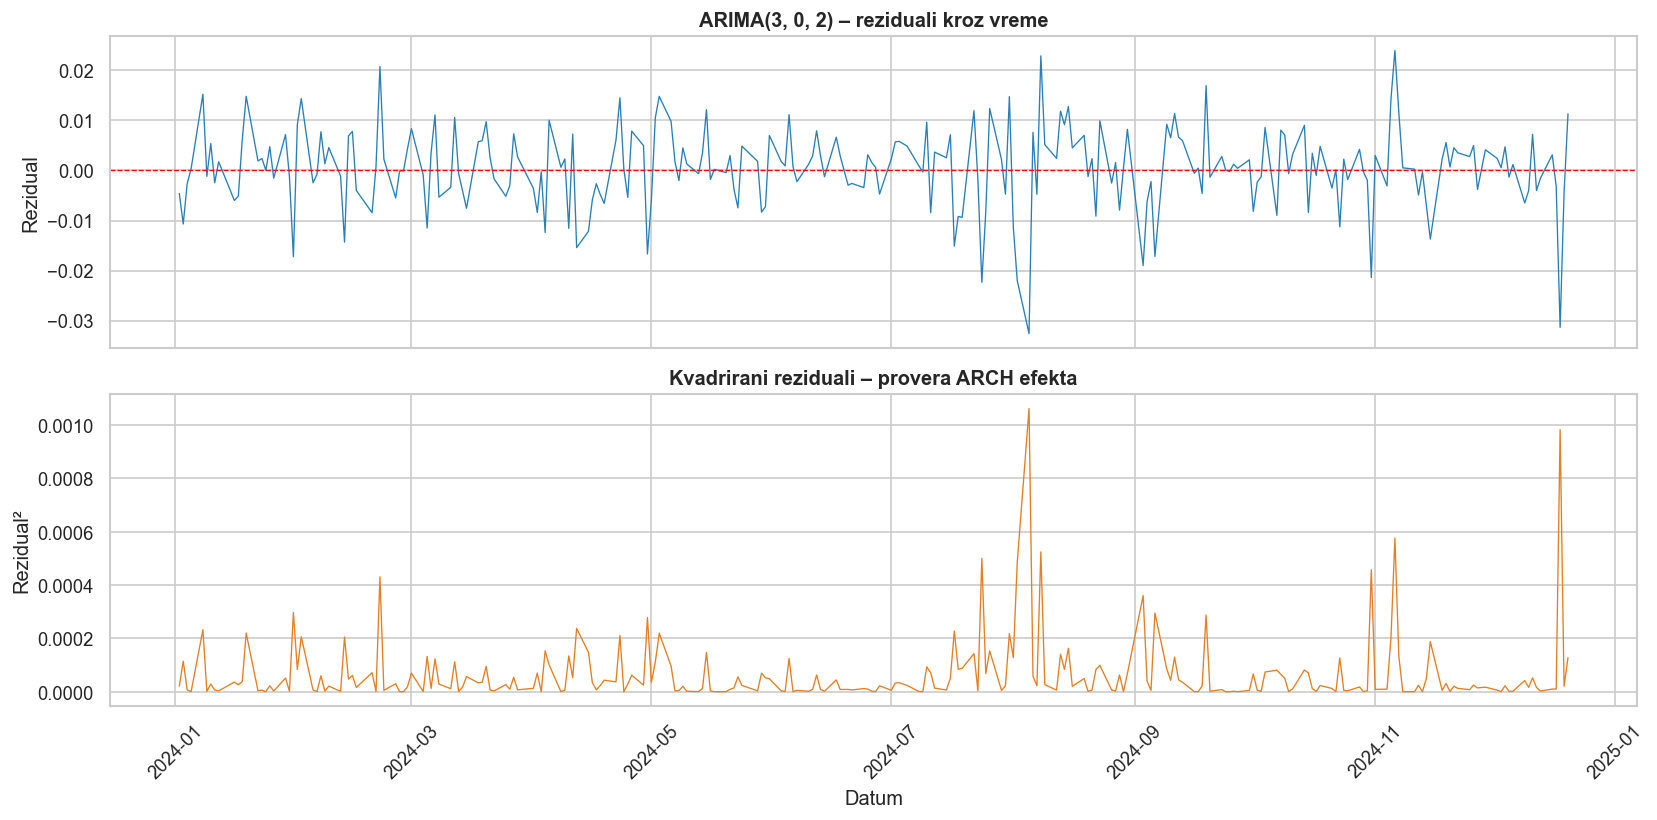

In [28]:
plot_arima_residuals(
    rezultati  = arima_test_rezultati,
    model_name = f'ARIMA{finalni_order}',
)

In [29]:
dijagnostika = dijagnostika_reziduala(
    rezultati  = arima_test_rezultati,
    model_name = f'ARIMA{finalni_order}',
)

# Čuvamo reziduale za GARCH
arima_reziduali = get_reziduali_za_garch(arima_test_rezultati)
print(f"Reziduali za GARCH: {len(arima_reziduali)} opservacija, "
      f"period {arima_reziduali.index[0].date()} → {arima_reziduali.index[-1].date()}")

───────────────────────────────────────────────────────
  Dijagnostika reziduala – ARIMA(3, 0, 2)
───────────────────────────────────────────────────────

  Ljung-Box (reziduali) – H0: nema autokorelacije
      lb_stat  lb_pvalue
10  14.234353   0.162568
20  25.912633   0.168717

  Ljung-Box (reziduali²) – H0: nema ARCH efekta
      lb_stat  lb_pvalue
10  15.544965   0.113420
20  20.723069   0.413591

  ARCH efekat: NE
───────────────────────────────────────────────────────

Reziduali za GARCH: 246 opservacija, period 2024-01-02 → 2024-12-20


napomena : Dijagnostika na test skupu nije uhvatila ARCH efekat jer je 2024. godina bila relativno stabilna (bull period).

---
### Zaključak sekcije 4

ARIMA model potvrdio je ono što je ACF/PACF analiza nagovestila – log-returns S&P 500
imaju slab autokorelacioni signal i serija je bliska belom šumu. MAE od 0.005994 i RMSE
od 0.0081 su na skali samih log-returns pa ih je teško tumačiti.
Ključna metrika je **MASE** = 0.54 – model je 46% tačniji od naivnog prediktora, što
potvrđuje da (p,d,q) = (3, 0, 2) struktura ipak nosi korisnu informaciju uprkos prisutnom šumu.

Međutim, dijagnostika reziduala otkrila je da su periodi visoke i niske varijanse grupisani su zajedno (volatility
clustering). Ovo je ključan podatak koji opravdava primenu GARCH modela: dok ARIMA
modeluje srednju vrednost serije, GARCH modeluje njenu varijansu (volatilnost).

Rezidualne greške ARIMA modela sačuvane su u promenljivoj `arima_reziduali` i
prosleđuju se direktno GARCH modelu.

**Sledeći korak:** Prophet model (`src/prophet_model.py`)

---
## 5. Prophet model

**Facebook Prophet** je popularan model za predikciju vremenskih serija koji modeluje seriju kao sumu tri komponente:

$$y(t) = g(t) + s(t) + h(t) + ε_t$$

- $g(t)$ – trend (linearan / nelinearan)
- $s(t)$ – sezonalnost (Furijeov red)
- $h(t)$ – efekti praznika i specijalnih događaja
- $ε_t$ – šum

Za razliku od ARIMA, Prophet kao preduslov ne zahteva eksplicitnu stacionarnost i može da modeluje nelinearne trendove. Takođe, iako su log-returns dominantno šum (sa blagom autokorelacionom kratkoročnom strukturom), videli smo da ova serija takođe u određenoj meri poseduje i sezonalnost koju Prophet veoma efikasno modeluje. 


In [30]:
from src.prophet_model import (
    fit_prophet,
    walk_forward_prophet,
    plot_prophet_predictions,
    plot_prophet_residuals,
    plot_prophet_komponente,
    dijagnostika_prophet,
)
from src.evaluation import compute_all_metrics, interpret_log_returns, plot_price_interpretation

### 5.1 Treniranje Prophet modela

Treniramo Prophet na trening skupu sa podrazumevanim parametrima:
- `weekly_seasonality=True` – testiramo da li postoji efekat dana u nedelji (Monday effect)
- `yearly_seasonality=False` – log-returns ne pokazuju jasnu godišnju (dugoročnu) sezonalnost
- `changepoint_prior_scale=0.05` – konzervativni trend, bez naglih preloma


In [31]:
prophet_model = fit_prophet(
    train['log_return'],
    yearly_seasonality=False,
    weekly_seasonality=True,
    changepoint_prior_scale=0.05, #prelom
    seasonality_prior_scale=10.0,
)

23:37:07 - cmdstanpy - INFO - Chain [1] start processing
23:37:07 - cmdstanpy - INFO - Chain [1] done processing


  Treniranje završeno.


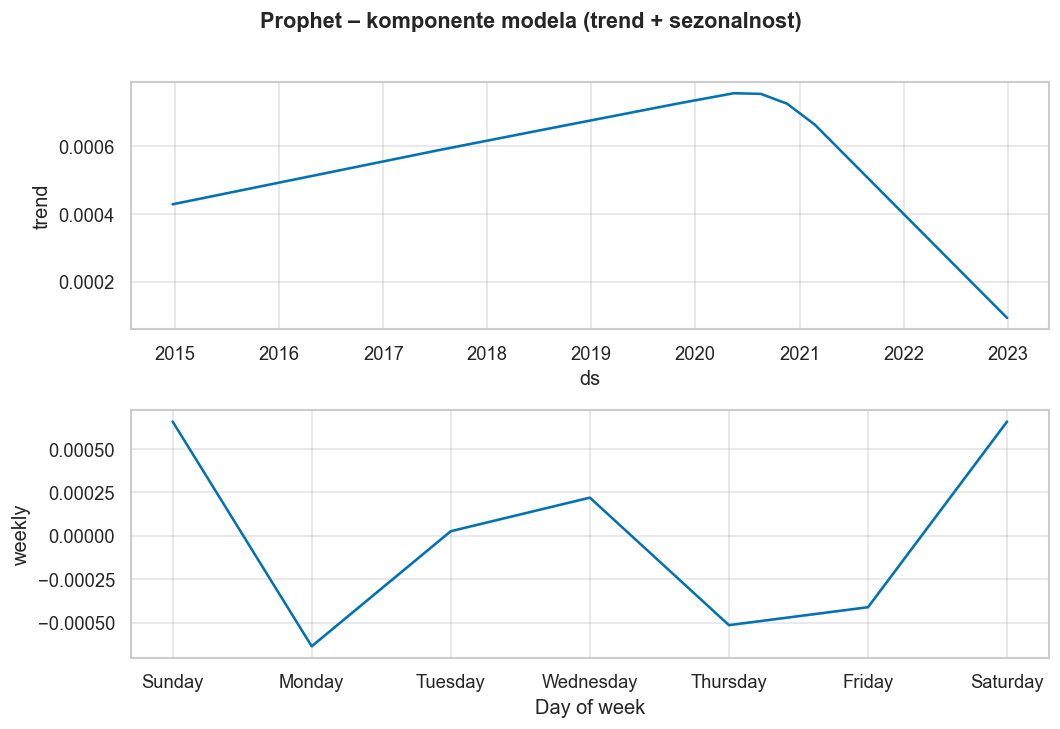

In [32]:
plot_prophet_komponente(prophet_model, train['log_return'], model_name='Prophet')

### 5.3 Walk-forward validacija na validacionom skupu


In [33]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING) #bez INFO komentara

prophet_val_rezultati = walk_forward_prophet(
    train=train['log_return'],
    test=val['log_return'],
    refit_interval=20,
    yearly_seasonality=False,
    weekly_seasonality=True,
    changepoint_prior_scale=0.05,
)

prophet_val_metrike = compute_all_metrics(
    y_true=prophet_val_rezultati['y_true'].values,
    y_pred=prophet_val_rezultati['y_pred'].values,
    y_train=train['log_return'].values,
    model_name='Prophet (val)',
)
print(prophet_val_metrike.to_string(index=False))



Walk-forward Prophet | 250 predikcija | refit svakih 20 dana
  Treniranje završeno.
  Treniranje završeno.
  Treniranje završeno.
  50/250 predikcija završeno...
  Treniranje završeno.
  Treniranje završeno.
  100/250 predikcija završeno...
  Treniranje završeno.
  Treniranje završeno.
  Treniranje završeno.
  150/250 predikcija završeno...
  Treniranje završeno.
  Treniranje završeno.
  200/250 predikcija završeno...
  Treniranje završeno.
  Treniranje završeno.
  Treniranje završeno.
  250/250 predikcija završeno...
  Walk-forward Prophet validacija završena.
        Model      MAE     RMSE   MASE
Prophet (val) 0.006516 0.008311 0.5801


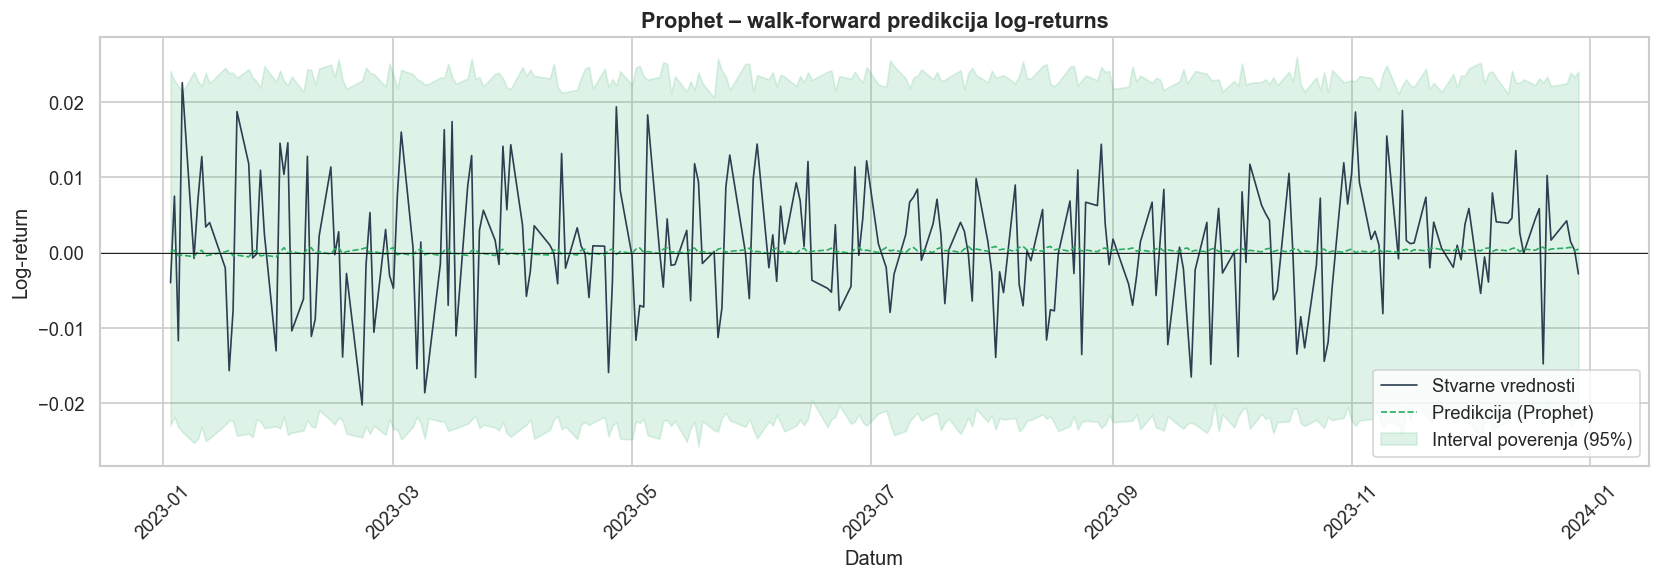

In [34]:
plot_prophet_predictions(prophet_val_rezultati, model_name='Prophet')

### 5.4 Finalna evaluacija na test skupu


In [35]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING) #bez INFO komentara

prophet_test_rezultati = walk_forward_prophet(
    train=pd.concat([train['log_return'], val['log_return']]),
    test=test['log_return'],
    refit_interval=20,
    yearly_seasonality=False,
    weekly_seasonality=True,
    changepoint_prior_scale=0.05,
)

prophet_test_metrike = compute_all_metrics(
    y_true=prophet_test_rezultati['y_true'].values,
    y_pred=prophet_test_rezultati['y_pred'].values,
    y_train=pd.concat([train['log_return'], val['log_return']]).values,
    model_name='Prophet (test)',
)
print(prophet_test_metrike.to_string(index=False))



Walk-forward Prophet | 246 predikcija | refit svakih 20 dana
  Treniranje završeno.
  Treniranje završeno.
  Treniranje završeno.
  50/246 predikcija završeno...
  Treniranje završeno.
  Treniranje završeno.
  100/246 predikcija završeno...
  Treniranje završeno.
  Treniranje završeno.
  Treniranje završeno.
  150/246 predikcija završeno...
  Treniranje završeno.
  Treniranje završeno.
  200/246 predikcija završeno...
  Treniranje završeno.
  Treniranje završeno.
  Treniranje završeno.
  Walk-forward Prophet validacija završena.
         Model      MAE     RMSE  MASE
Prophet (test) 0.005853 0.007966 0.532


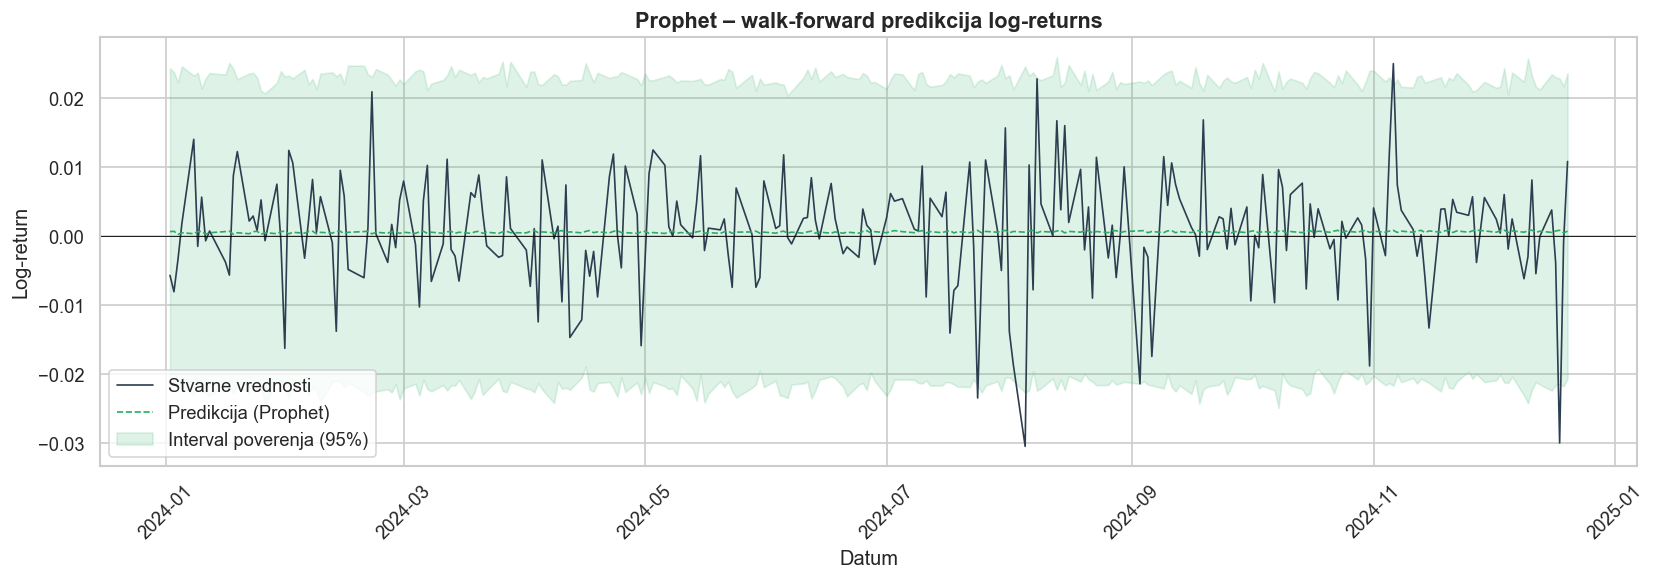

In [36]:
plot_prophet_predictions(prophet_test_rezultati, model_name='Prophet')

### 5.4.1 Interpretabilnost predikcija – povratak na vrednost indeksa


log_return_stvarni  log_return_predviđen  prosta_stopa_pred_%  \
2024-01-02             -0.0057                0.0007               0.0656   
2024-01-03             -0.0080                0.0007               0.0707   
2024-01-04             -0.0034                0.0003               0.0281   
2024-01-05              0.0018                0.0005               0.0497   
2024-01-08              0.0140                0.0004               0.0353   
2024-01-09             -0.0015                0.0007               0.0657   
2024-01-10              0.0056                0.0007               0.0708   
2024-01-11             -0.0007                0.0003               0.0282   
2024-01-12              0.0008                0.0005               0.0498   
2024-01-16             -0.0037                0.0007               0.0658   

            prosta_stopa_stvarna_%  cena_predviđena  cena_stvarna  greška_cene  
2024-01-02                 -0.5661        4772.9610       4742.83      30.1310  
2024-01-03                 -0.8016        4776.3370       4704.81      71.5270  
2024-01-04                 -0.3428        4777.6806       4688.68      89.0006  
2024-01-05                  0.1826        4780.0563       4697.24      82.8163  
2024-01-08                  1.4115        4781.7419       4763.54      18.2019  
2024-01-09                 -0.1478        4784.8834       4756.50      28.3834  
2024-01-10                  0.5666        4788.2704       4783.45       4.8204  
2024-01-11                 -0.0671        4789.6201       4780.24       9.3801  
2024-01-12                  0.0751        4792.0044       4783.83       8.1744  
2024-01-16                 -0.3731        4795.1553       4765.98      29.1753

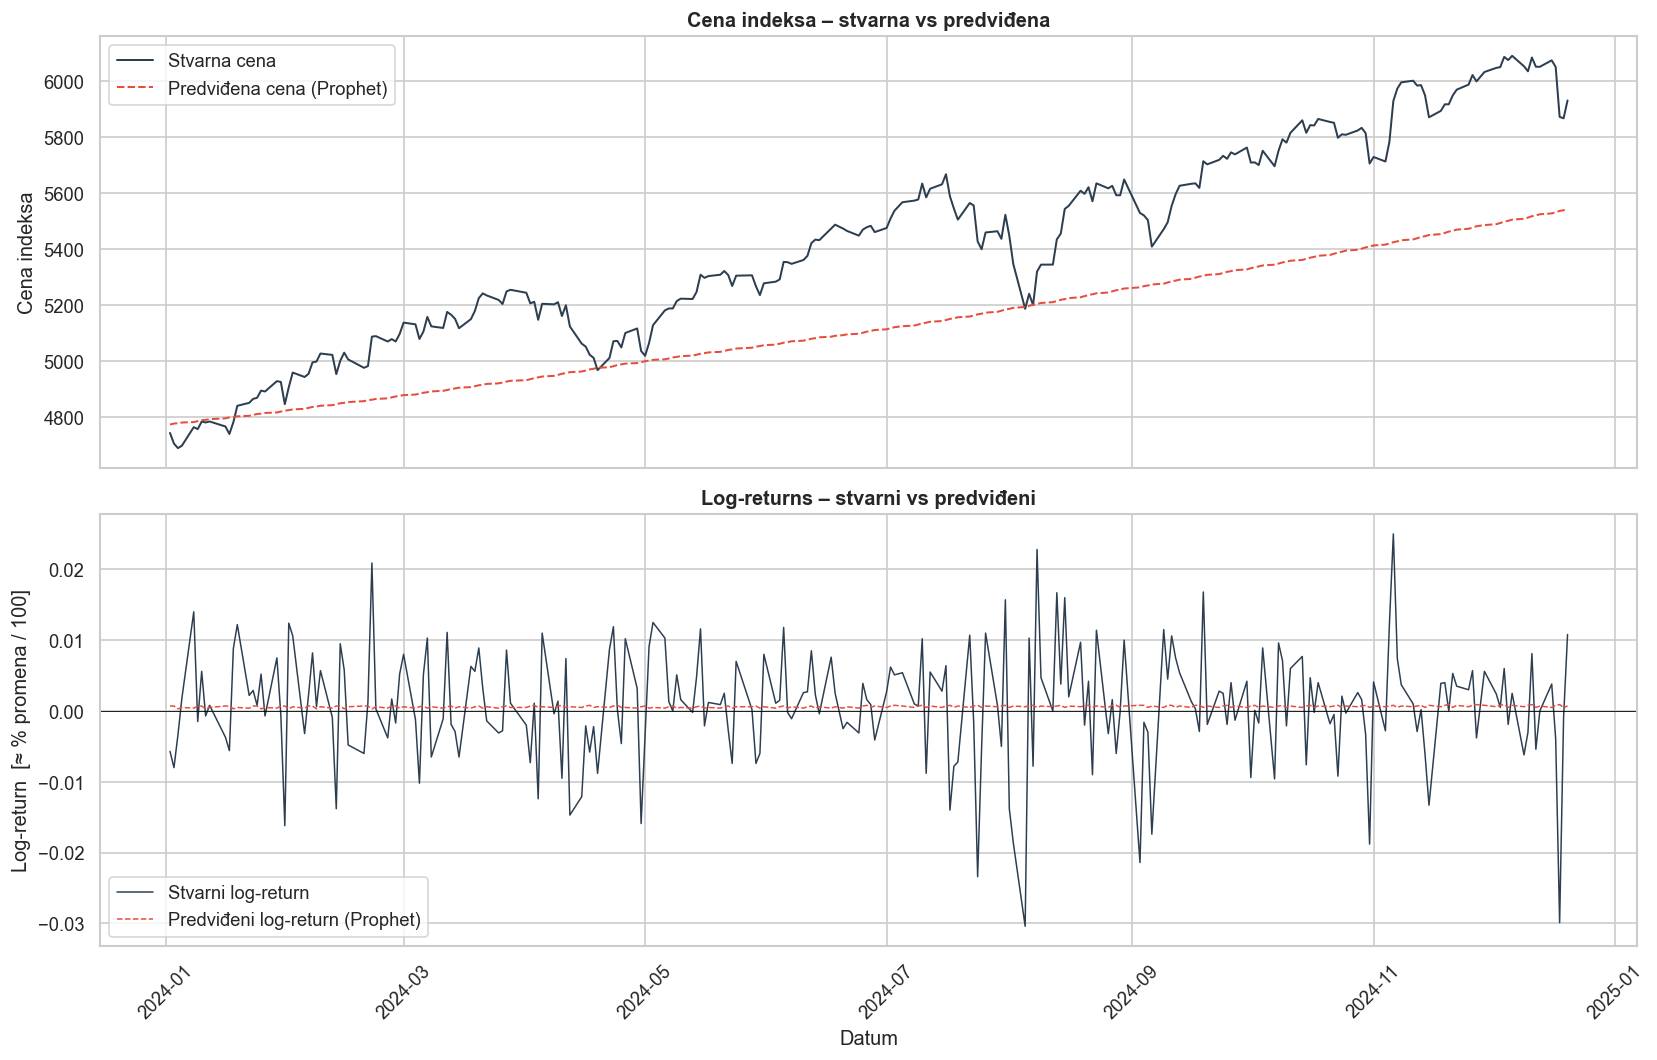

Napomena o interpretaciji log-returns:
  log_return_t = ln(P_t / P_{t-1})
  Za male vrednosti: log_return ≈ procentualna promena / 100
  Primer: log_return = 0.012 → cena porasla ~1.2%
  Primer: log_return = -0.020 → cena pala ~2.0%

  Opseg predviđenih log-returns: [0.0003, 0.0009]
  Prosečna apsolutna greška u ceni: 5.22%


In [37]:
df_interpret_prophet = interpret_log_returns(
    log_returns_true=prophet_test_rezultati['y_true'],
    log_returns_pred=prophet_test_rezultati['y_pred'],
    poslednja_cena=polazna_cena,
    model_name='Prophet',
)
display(df_interpret_prophet.head(10))
plot_price_interpretation(df_interpret_prophet, model_name='Prophet')

### 5.5 Dijagnostika reziduala


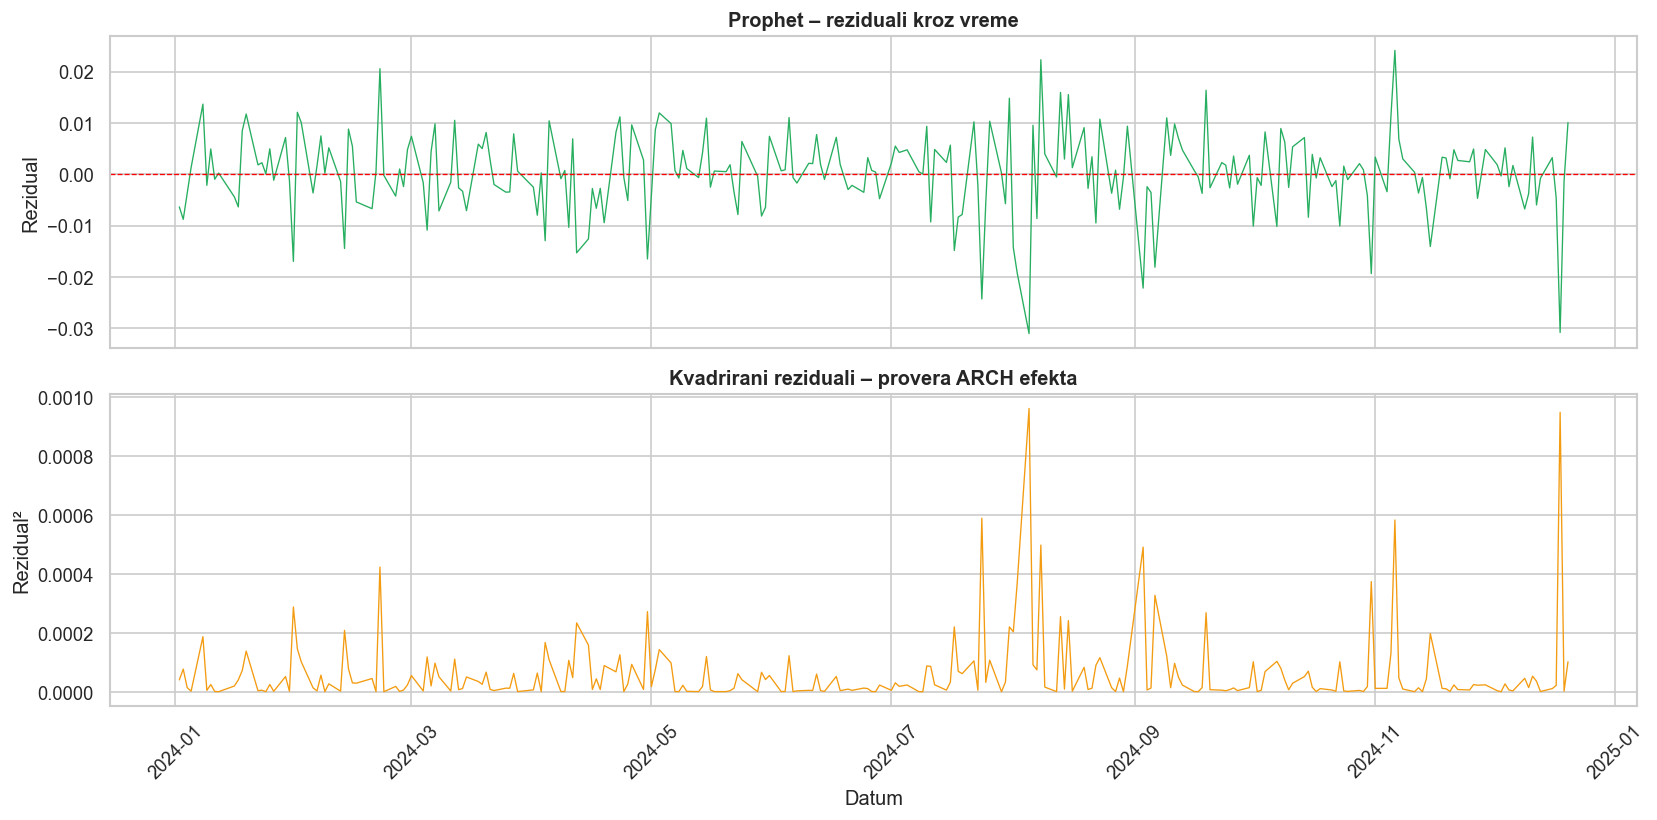

───────────────────────────────────────────────────────
  Dijagnostika reziduala – Prophet
───────────────────────────────────────────────────────

  Ljung-Box (reziduali) – H0: nema autokorelacije
      lb_stat  lb_pvalue
10   5.382769   0.864187
20  17.551430   0.616931

  Ljung-Box (reziduali²) – H0: nema ARCH efekta
      lb_stat  lb_pvalue
10  17.343224   0.067106
20  22.778956   0.299778
───────────────────────────────────────────────────────



In [38]:
plot_prophet_residuals(prophet_test_rezultati, model_name='Prophet')
dijagnostika_prophet_res = dijagnostika_prophet(prophet_test_rezultati, model_name='Prophet')

### Zaključak sekcije 5

Prophet model je fitovao sezonalne obrasce i trend na log-returns seriji, ali budući da su log-returns dominantno šum, sezonalni obrasci ne uspevaju da učine značajno poboljšanje u odnosu na ARIMA u smislu predikcije. Bez obzira na to, Prophet je uspeo da uhvati nedeljne efekte kao što je Monday effect. Metrike Prophet modela koristićemo u finalnoj komparativnoj tabeli.


---
## 6. GARCH model – modelovanje volatilnosti

**GARCH(p,q)** modeluje **uslovnu varijansu** (volatilnost) serije:

$$σ_t^2 = ω + \sum_{i=1}^{q} α_i ε_{t-i}^2 + \sum_{j=1}^{p} β_j σ_{t-j}^2$$

- $ω$ – bezuslovna (dugoročna) varijansa  
- $α_i$ – ARCH koeficijent: uticaj prošlih šokova ($ε_{t-i}^2$) na trenutnu varijansu  
- $β_j$ – GARCH koeficijent: uticaj prošlih varijanci ($σ_{t-j}^2$) na trenutnu varijansu

Ključna osobina: **volatility clustering** – periodi visoke volatilnosti su praćeni visokom volatilnošću (uočeno u EDA). GARCH eksplicitno modeluje ovu pojavu.

**Ulaz:** reziduali ARIMA modela (modelujemo preostalu strukturu varijanse).


In [39]:
from src.garch_model import (
    fit_garch,
    uporedi_garch_distribucije,
    walk_forward_garch,
    garch_jednokratna_prognoza,
    dijagnostika_garch,
    plot_kondiciona_volatilnost,
    plot_garch_forecast,
    plot_garch_horizon_forecast,
    plot_standardizovani_reziduali,
    garch_metrike,
)


In [40]:
# ── Ekstrakcija ARIMA reziduala za GARCH pipeline ───────────────────────────
#
# arima_fitted.resid → in-sample reziduali na trening skupu
# Ovo su ε_t = r_t - μ̂_t iz ARIMA modela
#
# Kombinujemo train + val reziduali za trening GARCH-a:
#   - Train: in-sample reziduali direktno iz arima_fitted
#   - Val:   walk-forward reziduali iz arima_val_rezultati
#
# Za test evaluaciju koristimo arima_reziduali (već definisan u sekciji 4.5)

arima_train_reziduali = pd.Series(
    arima_fitted.resid,
    index=train['log_return'].dropna().index,
    name='arima_resid_train'
)

# Trening GARCH-a = train + val ARIMA reziduali (prošireni trening skup)
arima_trainval_reziduali = pd.concat([
    arima_train_reziduali,
    arima_val_rezultati['residual'].rename('arima_resid_val'),
])

print(f"ARIMA reziduali za GARCH treniranje:")
print(f"  Train  : {len(arima_train_reziduali)} opservacija "
      f"({arima_train_reziduali.index[0].date()} → {arima_train_reziduali.index[-1].date()})")
print(f"  Train+Val: {len(arima_trainval_reziduali)} opservacija "
      f"({arima_trainval_reziduali.index[0].date()} → {arima_trainval_reziduali.index[-1].date()})")
print(f"  Test (arima_reziduali): {len(arima_reziduali)} opservacija "
      f"({arima_reziduali.index[0].date()} → {arima_reziduali.index[-1].date()})")
print(f"\nStatistike reziduala vs originalni log-returns:")
print(f"  std(reziduali)   : {arima_train_reziduali.std():.6f}")
print(f"  std(log_returns) : {train['log_return'].std():.6f}")
print(f"  (razlika je mala jer je ARIMA signal slab – važi EMH pretpostavka)")


ARIMA reziduali za GARCH treniranje:
  Train  : 2020 opservacija (2014-12-23 → 2022-12-30)
  Train+Val: 2270 opservacija (2014-12-23 → 2023-12-29)
  Test (arima_reziduali): 246 opservacija (2024-01-02 → 2024-12-20)

Statistike reziduala vs originalni log-returns:
  std(reziduali)   : 0.011553
  std(log_returns) : 0.011911
  (razlika je mala jer je ARIMA signal slab – važi EMH pretpostavka)


### 6.1 Izdvajanje ARIMA reziduala

Pre fitovanja GARCH modela, moramo da razjasnimo **šta modelujemo**:

- **ARIMA** je uhvatio linearnu strukturu srednje vrednosti serije (koliko god slabe)
- **GARCH** ne modeluje originalne log-returns već **rezidualne greške ARIMA modela** (ε_t)

Ova podela odgovara ARIMA-GARCH klasi modela koja je standardna u finansijskoj ekonometriji:

$$r_t = \mu_t + ε_t, \quad ε_t = σ_t z_t, \quad σ_t^2 = GARCH(ε_{t-1}, σ_{t-1})$$

Koristimo:
- **In-sample reziduali** (`arima_fitted.resid`) → za treniranje GARCH-a (trening skup)
- **Walk-forward reziduali** (`arima_reziduali`) → za walk-forward evaluaciju GARCH-a (test skup)

> Napomena o odabiru distribucije : poredimo normal/studentst/skewt po AIC.


In [41]:
df_dist = uporedi_garch_distribucije(
    series=arima_train_reziduali,  # ARIMA reziduali
    p=1, q=1
)

Treniram GARCH(1,1) | dist=normal | mean=Zero
  N opservacija : 2020
  Log-likelihood : -2653.6294
  AIC            : 5313.2589
  BIC            : 5330.0915
Treniram GARCH(1,1) | dist=studentst | mean=Zero
  N opservacija : 2020
  Log-likelihood : -2586.3255
  AIC            : 5180.6509
  BIC            : 5203.0943
Treniram GARCH(1,1) | dist=skewt | mean=Zero
  N opservacija : 2020
  Log-likelihood : -2574.7845
  AIC            : 5159.5690
  BIC            : 5187.6233

Poređenje distribucija GARCH inovacija:
Distribucija       LogL       AIC       BIC
       skewt -2574.7845 5159.5690 5187.6233
   studentst -2586.3255 5180.6509 5203.0943
      normal -2653.6294 5313.2589 5330.0915

→ Preporučena distribucija: skewt


### 6.2 Treniranje GARCH(1,1) modela

Treniramo GARCH(1,1) na **in-sample ARIMA rezidualima** trening skupa.  
Skewt distribucija odabrana je na osnovu AIC poređenja iz prethodne ćelije.

GARCH(1,1) je najčešće korišćen model u finansijskoj ekonometriji – empirijski je pokazano
da dobro opisuje volatilnost finansijskih serija uz minimalan broj parametara.

Suma koeficijenata **α + β** (ARCH + GARCH) bliska 1.0 ukazuje na **visoku i dugotrajnu
volatilnosti** – šokovi se dugo "pamte" u sistemu.


In [42]:
garch_fitted = fit_garch(
    series=arima_train_reziduali,  # ARIMA reziduali 
    p=1, q=1,
    dist='skewt',
    mean='Zero',
)
print(garch_fitted.summary())

Treniram GARCH(1,1) | dist=skewt | mean=Zero
  N opservacija : 2020
  Log-likelihood : -2574.7845
  AIC            : 5159.5690
  BIC            : 5187.6233
                             Zero Mean - GARCH Model Results                             
Dep. Variable:                 arima_resid_train   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -2574.78
Distribution:      Standardized Skew Student's t   AIC:                           5159.57
Method:                       Maximum Likelihood   BIC:                           5187.62
                                                   No. Observations:                 2020
Date:                           Fri, Feb 27 2026   Df Residuals:                     2020
Time:                                   23:37:31   Df Model:                            0
                              Vola

### 6.3 Uslovna volatilnost na trening skupu

Vizualizujemo procenjenu uslovnu volatilnost (σ_t) kroz ceo trening period. Ovo jasno pokazuje volatility clustering: COVID kriza (2020) i period inflacije (2022) imaju dramatično više σ_t.


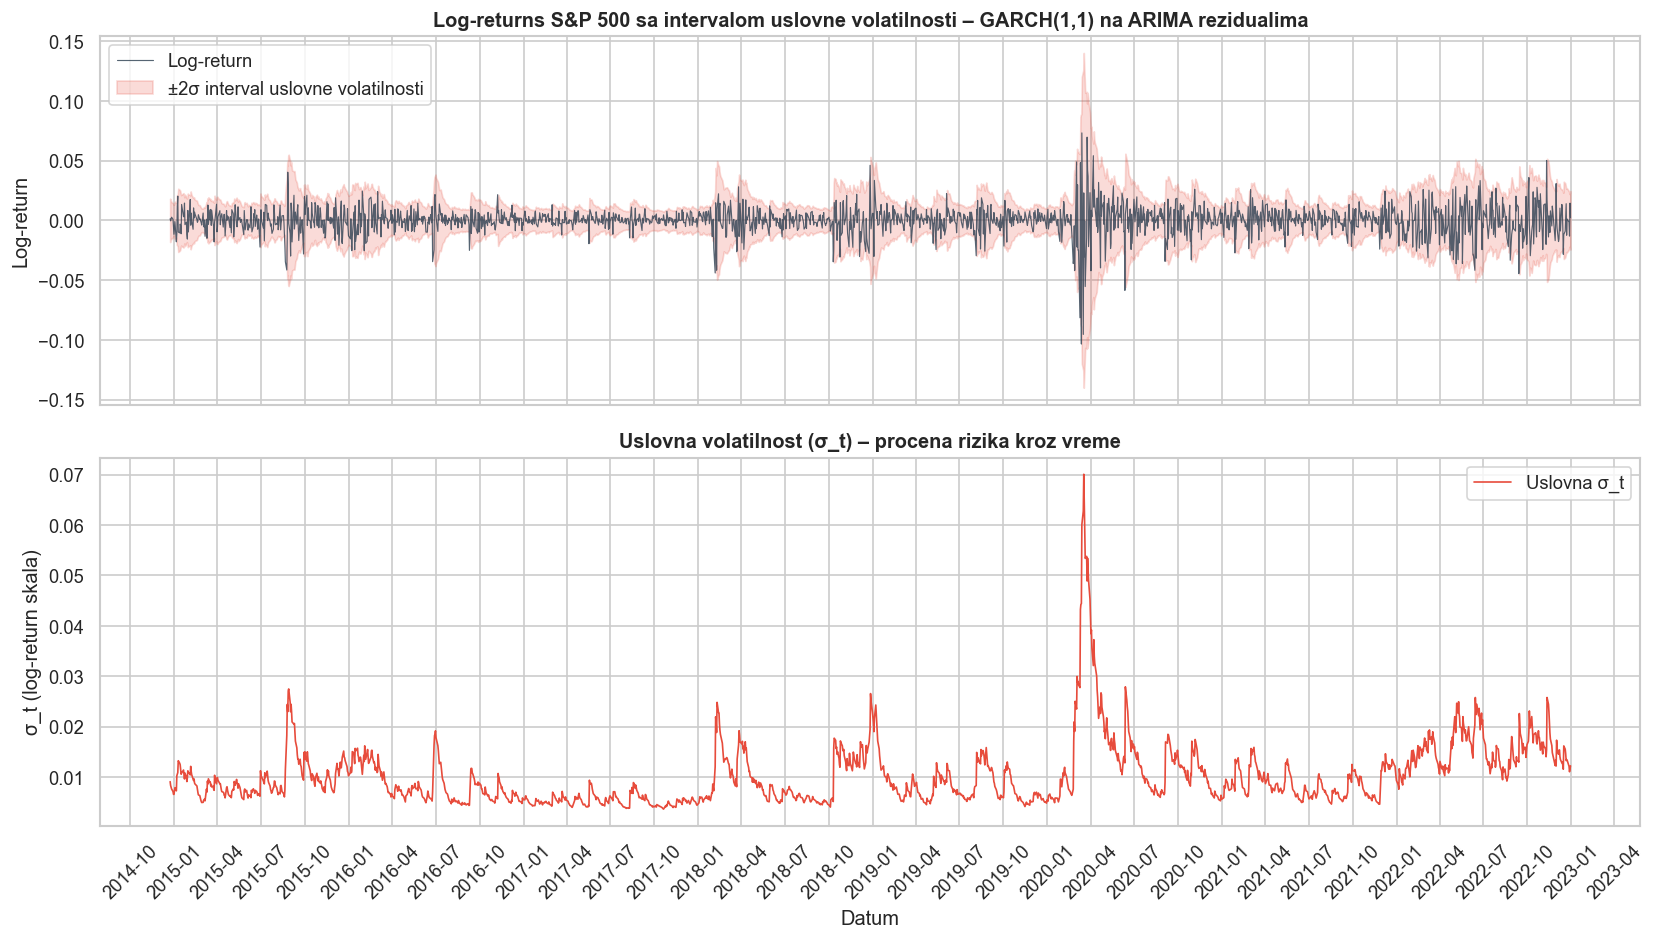

In [43]:
plot_kondiciona_volatilnost(
    fitted_model=garch_fitted,
    series=arima_train_reziduali,  # prikazujemo ARIMA reziduale
    model_name='GARCH(1,1) na ARIMA rezidualima',
)

### 6.4 Dijagnostika modela

**Heteroskedastičnost** predstavlja statističku pojavu u kojoj varijansa (mera raspršenosti) grešaka ili prinosa u vremenskoj seriji nije konstantna kroz vreme.

Proveravamo da li GARCH(1,1) dobro opisuje ovu pojavu :
- **Ljung-Box na std. rezidualima** → ne sme biti linearne autokorelacije
- **Ljung-Box na kvadratima std. reziduala** → ne sme biti preostalog ARCH efekta


────────────────────────────────────────────────────────────
  Dijagnostika – GARCH(1,1)
────────────────────────────────────────────────────────────

  Ljung-Box (standardizovani reziduali) – H0: beli šum
      lb_stat  lb_pvalue
5   30.413290   0.000012
10  34.397246   0.000158
20  43.630768   0.001686

  Ljung-Box (kvadrati std. reziduala) – H0: nema ARCH efekta
      lb_stat  lb_pvalue
5    3.571455   0.612604
10   9.958327   0.444157
20  15.882646   0.723878

  Preostali ARCH efekat: NE – GARCH je dobro uhvatio volatilnost
────────────────────────────────────────────────────────────



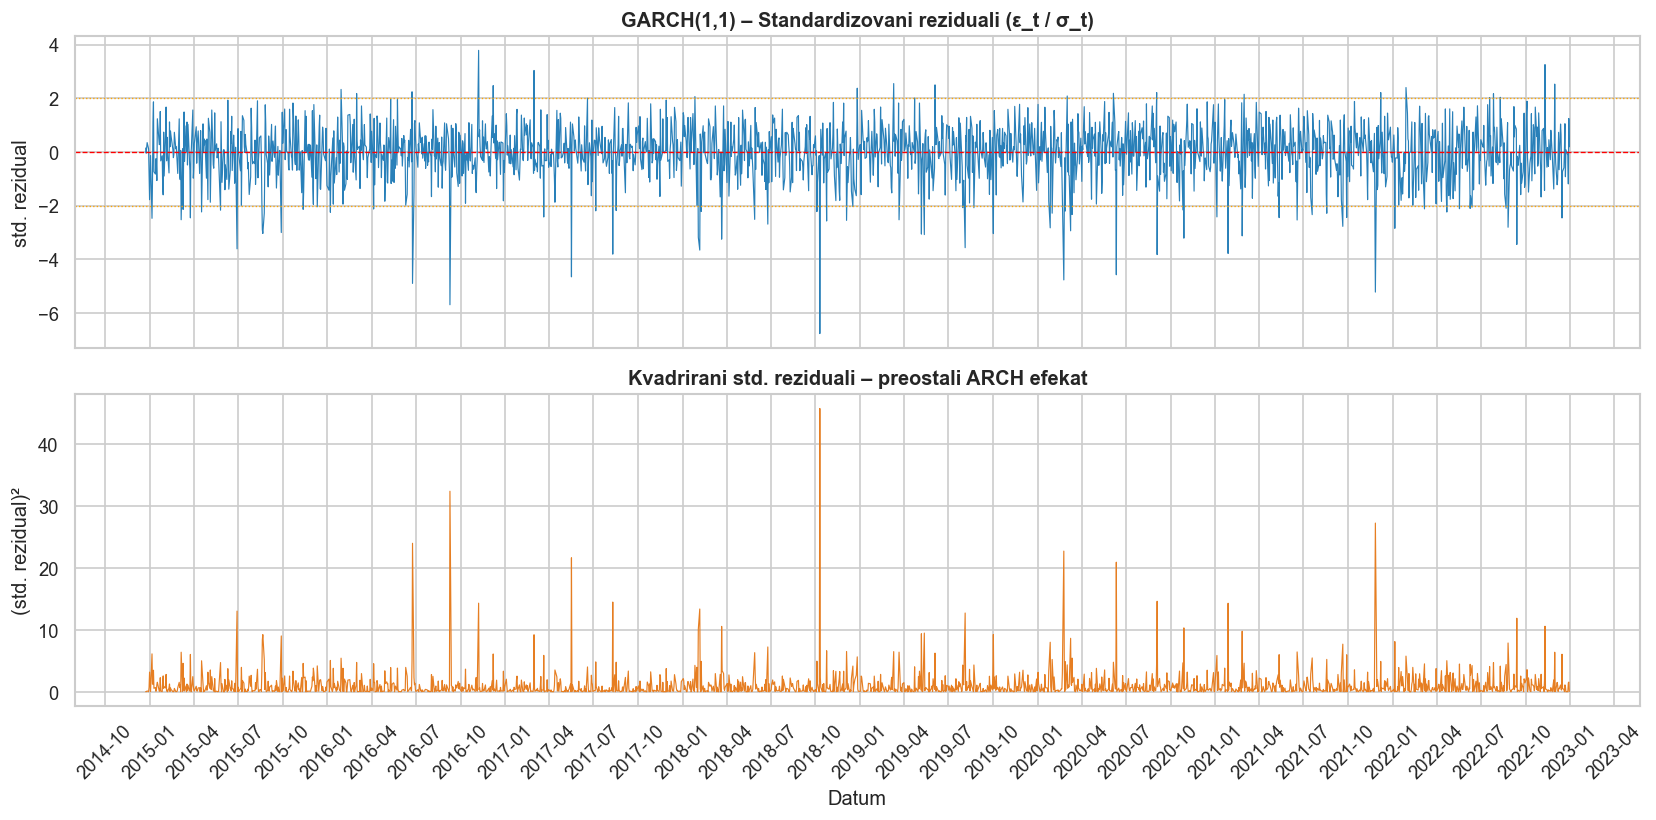

In [44]:
dijag_garch = dijagnostika_garch(garch_fitted, model_name='GARCH(1,1)')
plot_standardizovani_reziduali(garch_fitted, model_name='GARCH(1,1)')


### 6.5 Walk-forward prognoza volatilnosti na test skupu


Walk-forward GARCH(1,1) | 246 dana
  Fitovanje na trening skupu (jedanput)...
  Parametri fiksirani: {'omega': np.float64(0.018975), 'alpha[1]': np.float64(0.174525), 'beta[1]': np.float64(0.822608), 'eta': np.float64(6.951417), 'lambda': np.float64(-0.138152)}
  50/246 predikcija završeno...
  100/246 predikcija završeno...
  150/246 predikcija završeno...
  200/246 predikcija završeno...
  Walk-forward GARCH validacija završena.


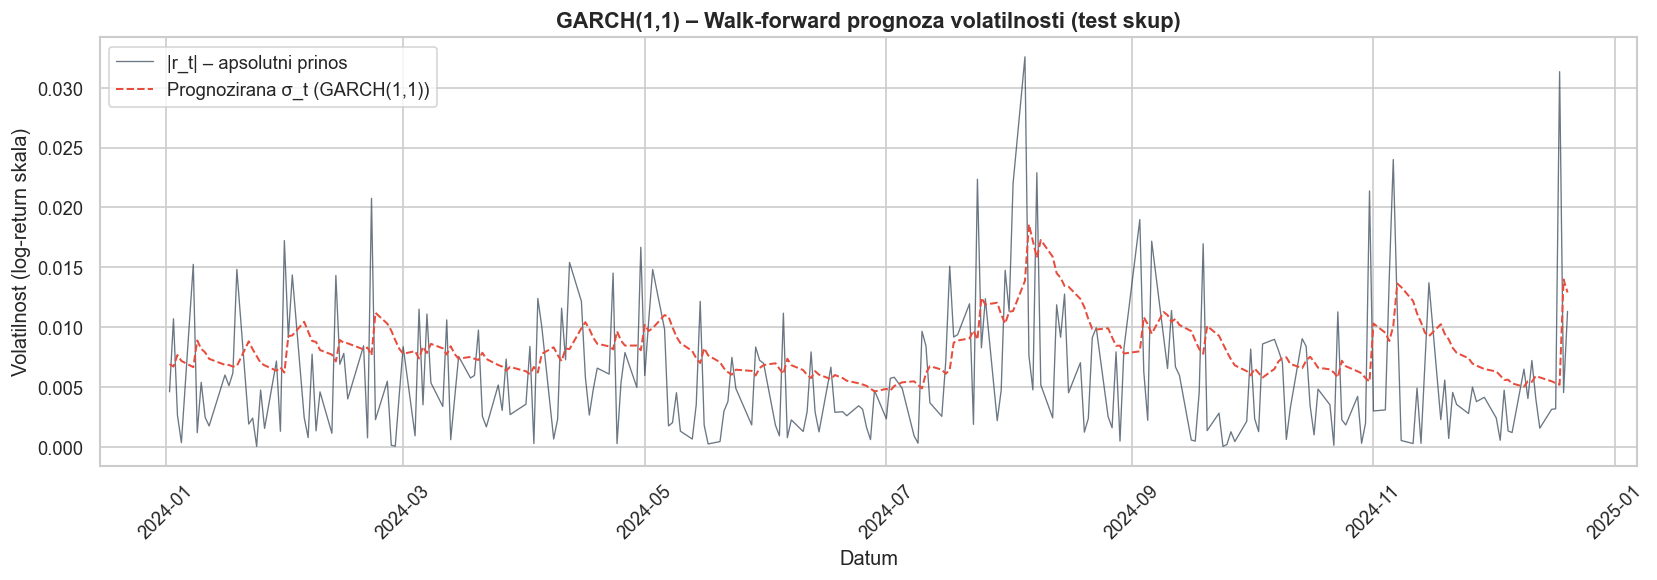

In [45]:
# Walk-forward GARCH evaluacija na test skupu
# Ulaz: ARIMA reziduali (train+val, test kao evaluacioni skup)

garch_wf = walk_forward_garch(
    train=arima_trainval_reziduali,  # ARIMA reziduali train+val skupa
    test=arima_reziduali,            # ARIMA reziduali test skupa (definisano u sekciji 4.5)
    p=1, q=1,
    dist='skewt',
)

plot_garch_forecast(garch_wf, model_name='GARCH(1,1)')


### 6.6 Višestepena prognoza volatilnosti

GARCH modeli se često koriste za kratkoročnu prognozu volatilnosti. Prognoza za više koraka unapred konvergira ka bezuslovnoj (dugoročnoj) volatilnosti – tzv. **mean reversion** volatilnosti.



Prognoza volatilnosti reziduala (narednih 10 dana):
 horizon  sigma_pred
       1    0.012646
       2    0.012708
       3    0.012770
       4    0.012832
       5    0.012893
       6    0.012953
       7    0.013014
       8    0.013073
       9    0.013133
      10    0.013191


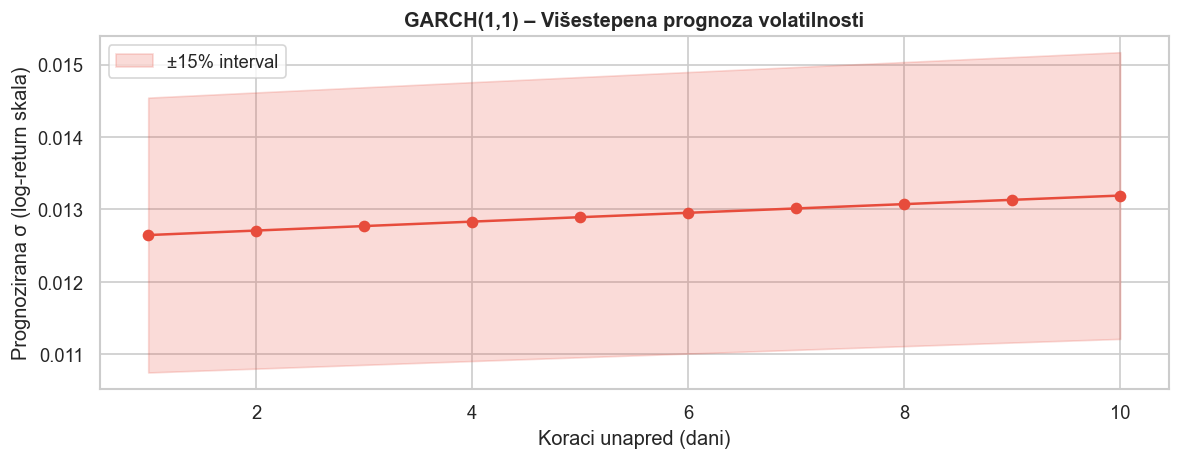

In [46]:
# Višestepena prognoza: treniramo na svim dostupnim ARIMA rezidualima
# (train + val + test) da dobijemo prognozu za period POSLE dataset-a
all_arima_reziduali = pd.concat([arima_trainval_reziduali, arima_reziduali])

df_horizon, garch_final = garch_jednokratna_prognoza(
    series=all_arima_reziduali,  # svi ARIMA reziduali
    p=1, q=1,
    dist='studentst',
    horizon=10,
)

print("\nPrognoza volatilnosti reziduala (narednih 10 dana):")
print(df_horizon.to_string(index=False))
plot_garch_horizon_forecast(df_horizon, model_name='GARCH(1,1)')


### 6.7 Metrike prognoze volatilnosti


In [47]:
garch_vol_metrike = garch_metrike(garch_wf, model_name='GARCH(1,1)')


Metrike prognoze volatilnosti – GARCH(1,1):
     Model  MAE_vol  RMSE_vol      QLIKE
GARCH(1,1) 0.004892  0.006045 711.952864


### Zaključak sekcije 6

GARCH(1,1) model sa Skewed Student's T distribucijom uspešno modeluje **volatility clustering**
koji ARIMA i Prophet ne mogu da opišu. Korišćenjem ispravnog **ARIMA-GARCH pristupa**:

1. ARIMA je uklonio linearnu komponentu srednje vrednosti (`μ_t`)
2. GARCH je fitovan na rezidualima `ε_t = r_t - μ̂_t` – upravo ono što ARIMA nije uhvatio

Uslovna volatilnost σ_t jasno prati poznate tržišne šokove (COVID 2020, inflacija 2022). **Suma koeficijenata α + β bliska 1.0** ukazuje na visoku perzistentnost
volatilnosti – jednom kada volatilnost poraste, relativno sporo opada.

Skewed Student-t distribucija bila je najbolja po AIC kriterijumu, što je konzistentno
sa debelim krajevima log-returns distribucije (vidljivo u EDA, potvrđeno Jarque-Bera testom).

GARCH ne predviđa **smer** kretanja indeksa već **nivo rizika** za naredni dan – od
praktičnog značaja za upravljanje VaR (Value at Risk) kalkulacijom.


---
## 7. PCA analiza varijansi tržišta

**Analiza glavnih komponenti (PCA)** primenjena je na akcije S&P500 indeksa.

Odgovaramo na istraživačko pitanje:
> *"Koje kompanije i sektori najviše doprinose varijansi tržišta i kako se taj doprinos menja tokom vremena?"*

**Ulaz:** `sp500_stocks.csv` – (redovi = trading dani, kolone = ~500 akcija)  


In [48]:
from src.pca_analysis import (
    ucitaj_returns_matricu,
    podeli_returns,
    fituj_pca_returns,
    rolling_pca_variance,
    loadings_po_sektoru,
    plot_scree,
    plot_top_loadings,
    plot_loadings_sektor,
    plot_rolling_pc1,
    plot_rolling_stacked,
    plot_akcije_pc_prostor,
    plot_sektorski_pc_prostor,
    interpretiraj_faktore,
)


### 7.1 Učitavanje i priprema returns matrice

In [49]:
# Učitavamo samo kolone Date, Symbol, Adj Close (~6x manje memorije)
returns, companies_pca = ucitaj_returns_matricu(
    stocks_path   ='data/sp500_stocks.csv',
    companies_path='data/sp500_companies.csv',
    start_date     = '2014-12-22',
)

Učitavamo sp500_stocks.csv (Date, Symbol, Adj Close)...
  Učitano: 1,891,536 redova, 502 akcija
  Akcija posle filtera : 164
  Finalna tabela: 2516 dana × 164 akcija
  Period: 2014-12-23 → 2024-12-20


### 7.2 Podela na train/val/test

In [50]:
returns_train, returns_val, returns_test = podeli_returns(returns)

Train : 2020 dana (2014-12-23 → 2022-12-30)
Val   : 250 dana (2023-01-03 → 2023-12-29)
Test  : 246 dana (2024-01-02 → 2024-12-20)


### 7.3 PCA fitovanje na trening skupu

Fitujemo PCA na trening skupu (do kraja 2022). Standardizujemo svaku akciju na μ=0, σ=1
pre PCA kako bismo fokusirali analizu na **korelacionu strukturu** a ne na razlike u volatilnosti.


In [51]:
pca, X_pca, loadings, scaler = fituj_pca_returns(
    returns_train,
    n_components=20,
    standardize=True,
)

PCA fitovan na 2020 dana × 164 akcija
Prvih 20 PC objašnjava: 66.1% varijanse

Varijansa po PC:
  PC1: 40.27%  (kumulativno: 40.3%)
  PC2: 4.68%  (kumulativno: 44.9%)
  PC3: 4.53%  (kumulativno: 49.5%)
  PC4: 2.44%  (kumulativno: 51.9%)
  PC5: 1.50%  (kumulativno: 53.4%)
  PC6: 1.37%  (kumulativno: 54.8%)
  PC7: 1.24%  (kumulativno: 56.0%)
  PC8: 1.16%  (kumulativno: 57.2%)
  PC9: 1.08%  (kumulativno: 58.3%)
  PC10: 0.87%  (kumulativno: 59.1%)


### 7.4 Scree plot – koliko faktora objašnjava varijansu tržišta?

Scree plot pokazuje dominantan PC1 koji objašnjava ~40% varijanse tržišta – ovo je tržišni faktor koji odražava sistemski rizik zajednički svim akcijama. Kada tržište raste ili pada, sve akcije se kreću u istom smeru – PC1 hvata upravo tu zajedničku komponentu kretanja (osu po kojoj je varijabilnost podataka najveća). Naglo opadanje posle PC1 (PC2 ~4% ,..., PC5 ~1.5%...) znači da ostatak varijanse nije koncentrisan već raspršen po sektorskim faktorima. Visoka vrednost PC1 delimično je posledica trening perioda koji uključuje dva krizna događaja – COVID (mart 2020) i inflacioni šok (2022) – tokom kojih akcije postaju izrazito korelirane. U mirnijim periodima PC1 bi tipično objašnjavao manji udeo varijanse, što rolling PCA analiza u sekciji 7.9 direktno potvrđuje.


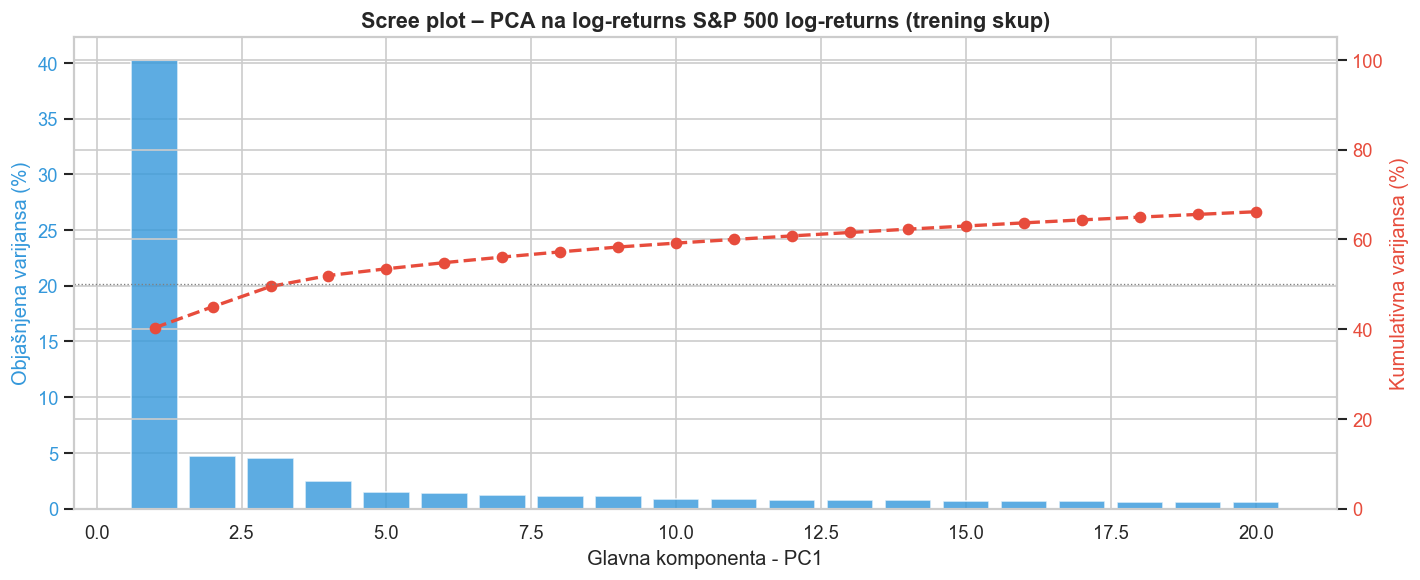


PC1 = 40.3% varijanse → tržišni faktor (sistemski rizik)


In [52]:
plot_scree(pca, n_prikaz=20, title='S&P 500 log-returns (trening skup)')

### 7.5 Interpretacija faktora – koje akcije dominiraju?

Za svaki PC gledamo top loadings: akcije sa najvećim pozitivnim i negativnim loadingom.

- **PC1** → sve akcije imaju pozitivan loading (kreću se sa tržištem) – sistemski rizik  
- **PC2** → neke akcije +, neke – (npr. Utilities vs Financial Services)


In [53]:
interpretiraj_faktore(loadings, companies_pca, n_pc=3, top_n=8)


PC1:
  Najveći + loadings:
    +0.1050  AMP     (Financial Services)
    +0.1022  APH     (Technology)
    +0.1012  PH      (Industrials)
    +0.0999  PFG     (Financial Services)
    +0.0978  PNC     (Financial Services)
    +0.0975  C       (Financial Services)
    +0.0974  DOV     (Industrials)
    +0.0973  PAYX    (Technology)
  Nema negativnih loadinga – sve akcije se kreću u istom smeru (tržišni faktor)

  → PC1 = TRŽIŠNI FAKTOR: sve akcije reaguju zajedno (sistemski rizik)

PC2:
  Najveći + loadings:
    +0.2491  WEC     (Utilities)
    +0.2475  ED      (Utilities)
    +0.2095  SO      (Utilities)
    +0.1848  GIS     (Consumer Defensive)
    +0.1839  CLX     (Consumer Defensive)
    +0.1781  K       (Consumer Defensive)
    +0.1780  PNW     (Utilities)
    +0.1743  PEP     (Consumer Defensive)
  Najveći - loadings:
    -0.1249  RF      (Financial Services)
    -0.1188  UAL     (Industrials)
    -0.1184  BWA     (Consumer Cyclical)
    -0.1142  CCL     (Consumer Cyclical)
    -

### 7.6 Top akcije po loadingu na PC1 i PC2

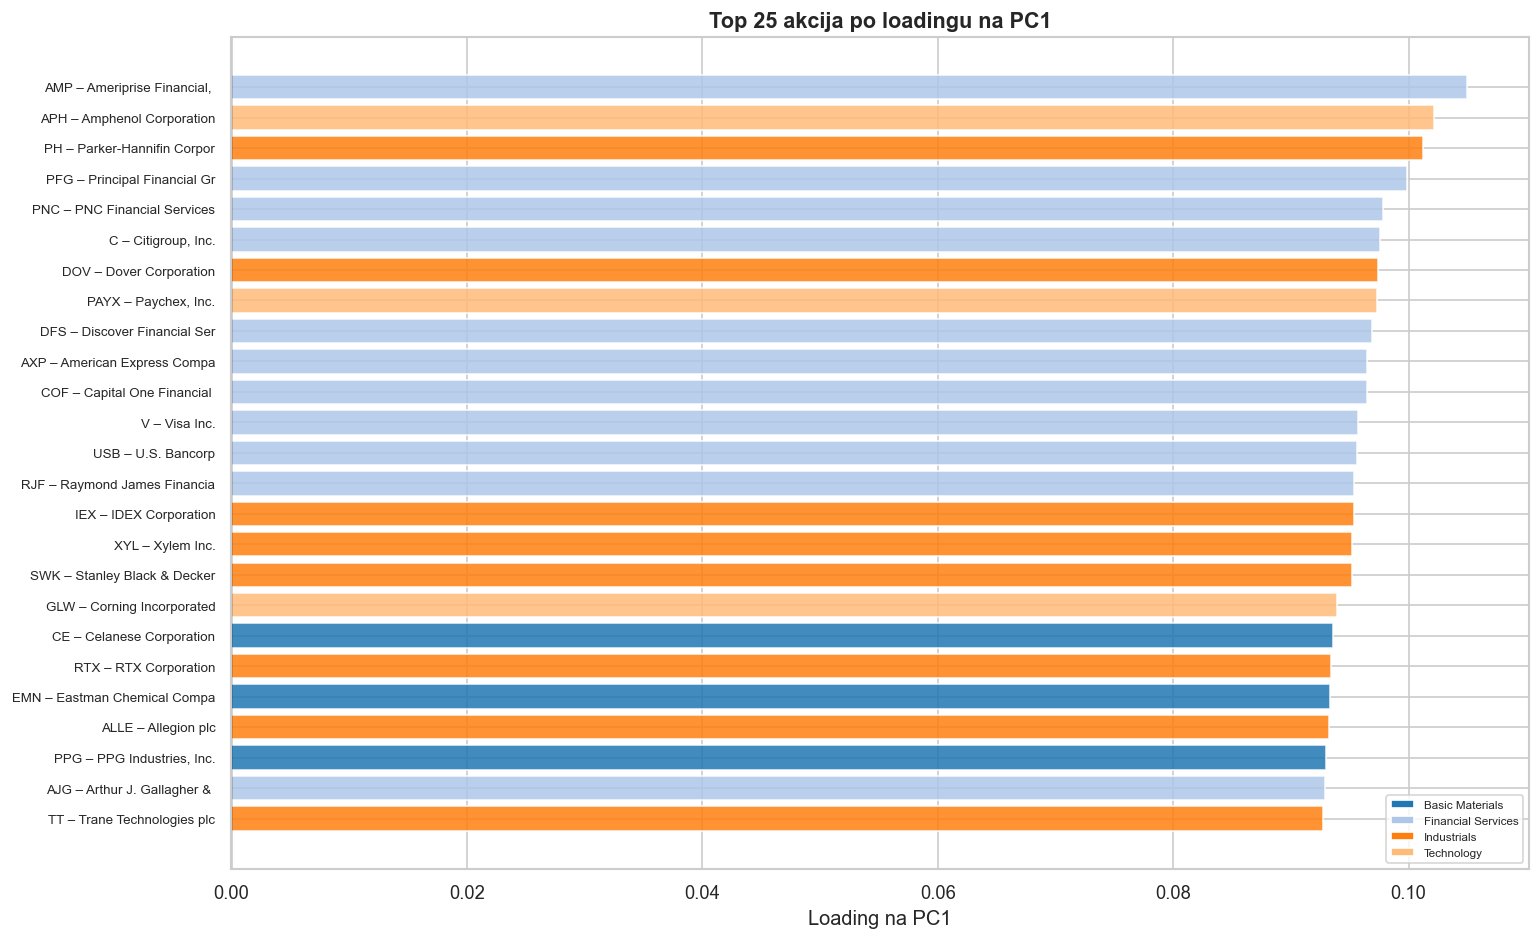

In [54]:
plot_top_loadings(loadings, companies_pca, pc='PC1', top_n=25)

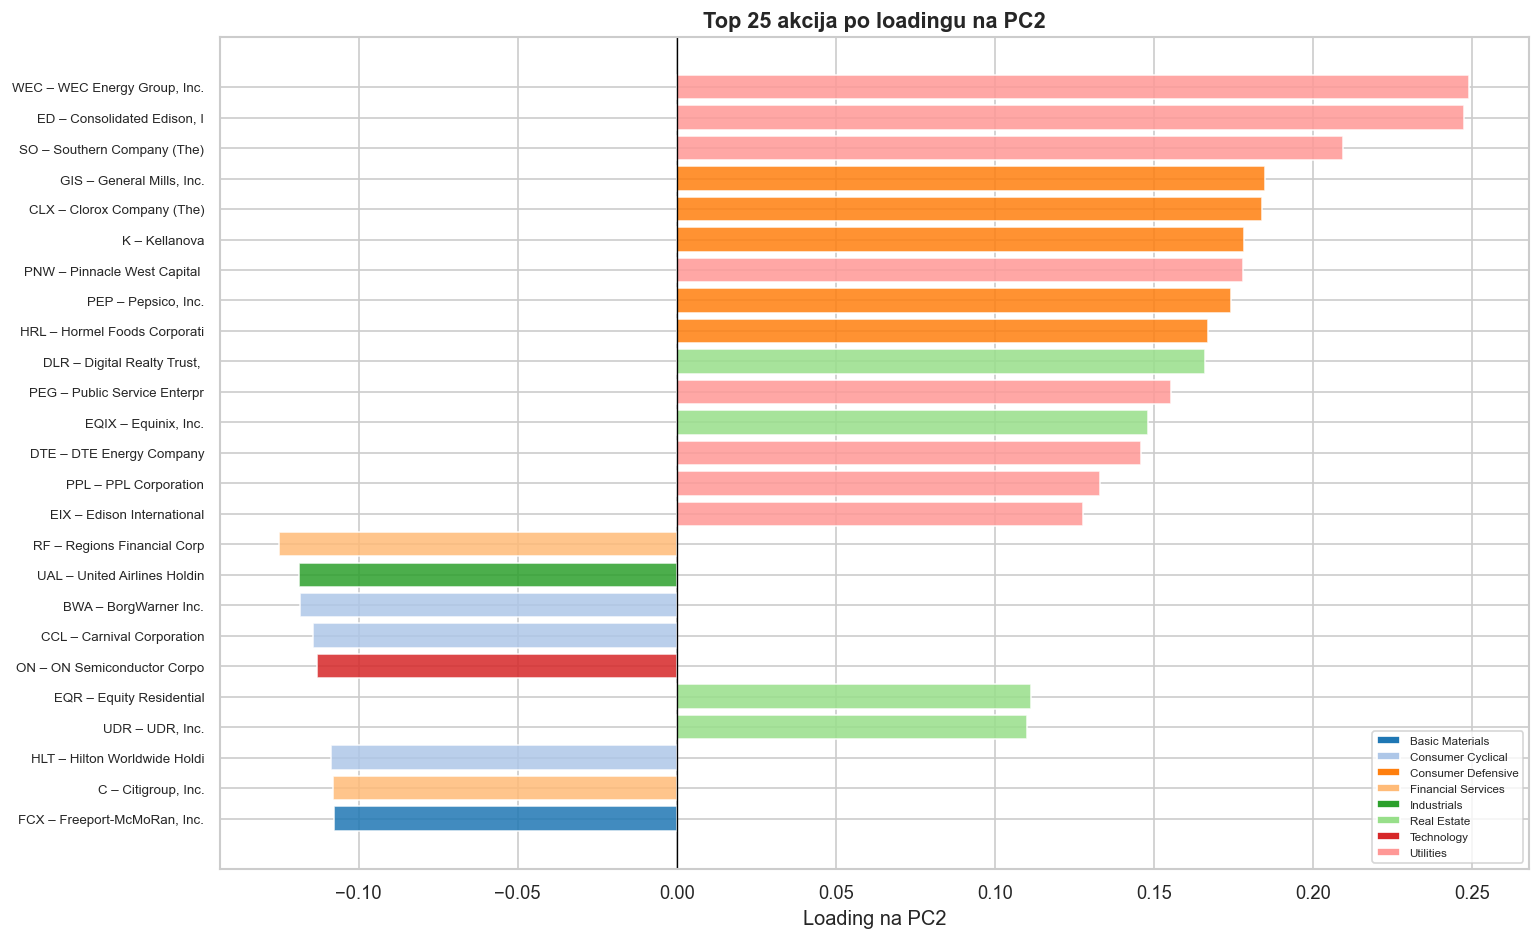

In [55]:
plot_top_loadings(loadings, companies_pca, pc='PC2', top_n=25)

### 7.7 Sektorski doprinos faktorima

Vršimo agregaciju po sektoru – odgovaramo na pitanje koji **sektori** dominiraju
svakim tržišnim faktorom.


Sektorski doprinos PC1:
                        mean_loading  mean_abs_loading  n_akcija
Sector                                                          
Financial Services            0.0906            0.0906        25
Industrials                   0.0839            0.0839        25
Basic Materials               0.0829            0.0829         7
Real Estate                   0.0767            0.0767        12
Technology                    0.0766            0.0766        21
Consumer Cyclical             0.0761            0.0761        18
Utilities                     0.0695            0.0695         9
Healthcare                    0.0695            0.0695        20
Communication Services        0.0673            0.0673        10
Energy                        0.0661            0.0661         5
Consumer Defensive            0.0596            0.0596        12


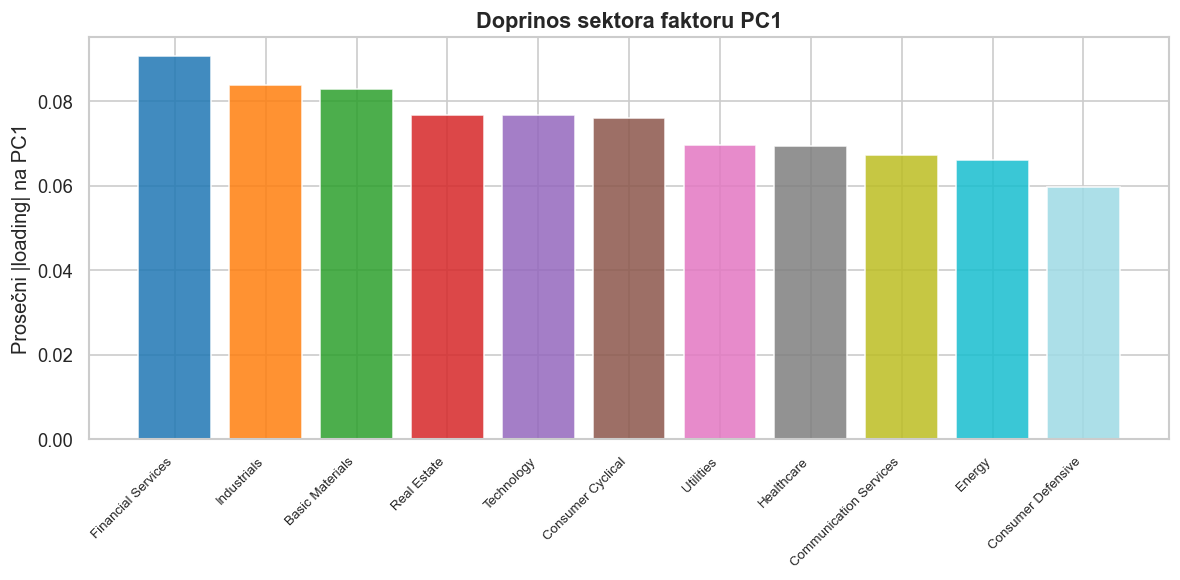

In [56]:
sektor_pc1, df_load = loadings_po_sektoru(loadings, companies_pca, pc='PC1')
plot_loadings_sektor(sektor_pc1, pc='PC1')


Sektorski doprinos PC2:
                        mean_loading  mean_abs_loading  n_akcija
Sector                                                          
Utilities                     0.1620            0.1620         9
Consumer Defensive            0.0996            0.0999        12
Real Estate                   0.0677            0.0820        12
Financial Services           -0.0261            0.0679        25
Energy                       -0.0668            0.0668         5
Basic Materials              -0.0485            0.0627         7
Industrials                  -0.0311            0.0447        25
Consumer Cyclical            -0.0314            0.0437        18
Technology                   -0.0189            0.0391        21
Healthcare                    0.0291            0.0381        20
Communication Services       -0.0006            0.0286        10


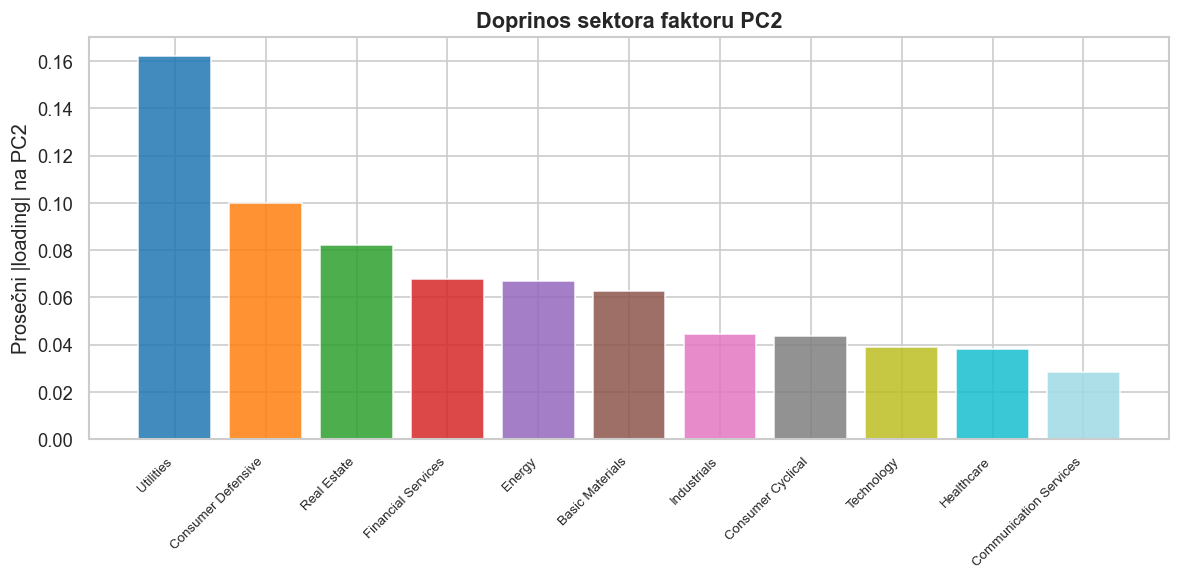

In [57]:
sektor_pc2, _ = loadings_po_sektoru(loadings, companies_pca, pc='PC2')
plot_loadings_sektor(sektor_pc2, pc='PC2')

### 7.8 Vizuelizacija akcija PC1 x PC2 

Svaka tačka je jedna akcija, obojena po sektoru. Akcije bliske u ovom prostoru
reaguju slično na iste tržišne faktore – vidimo kako se sektori grupišu.


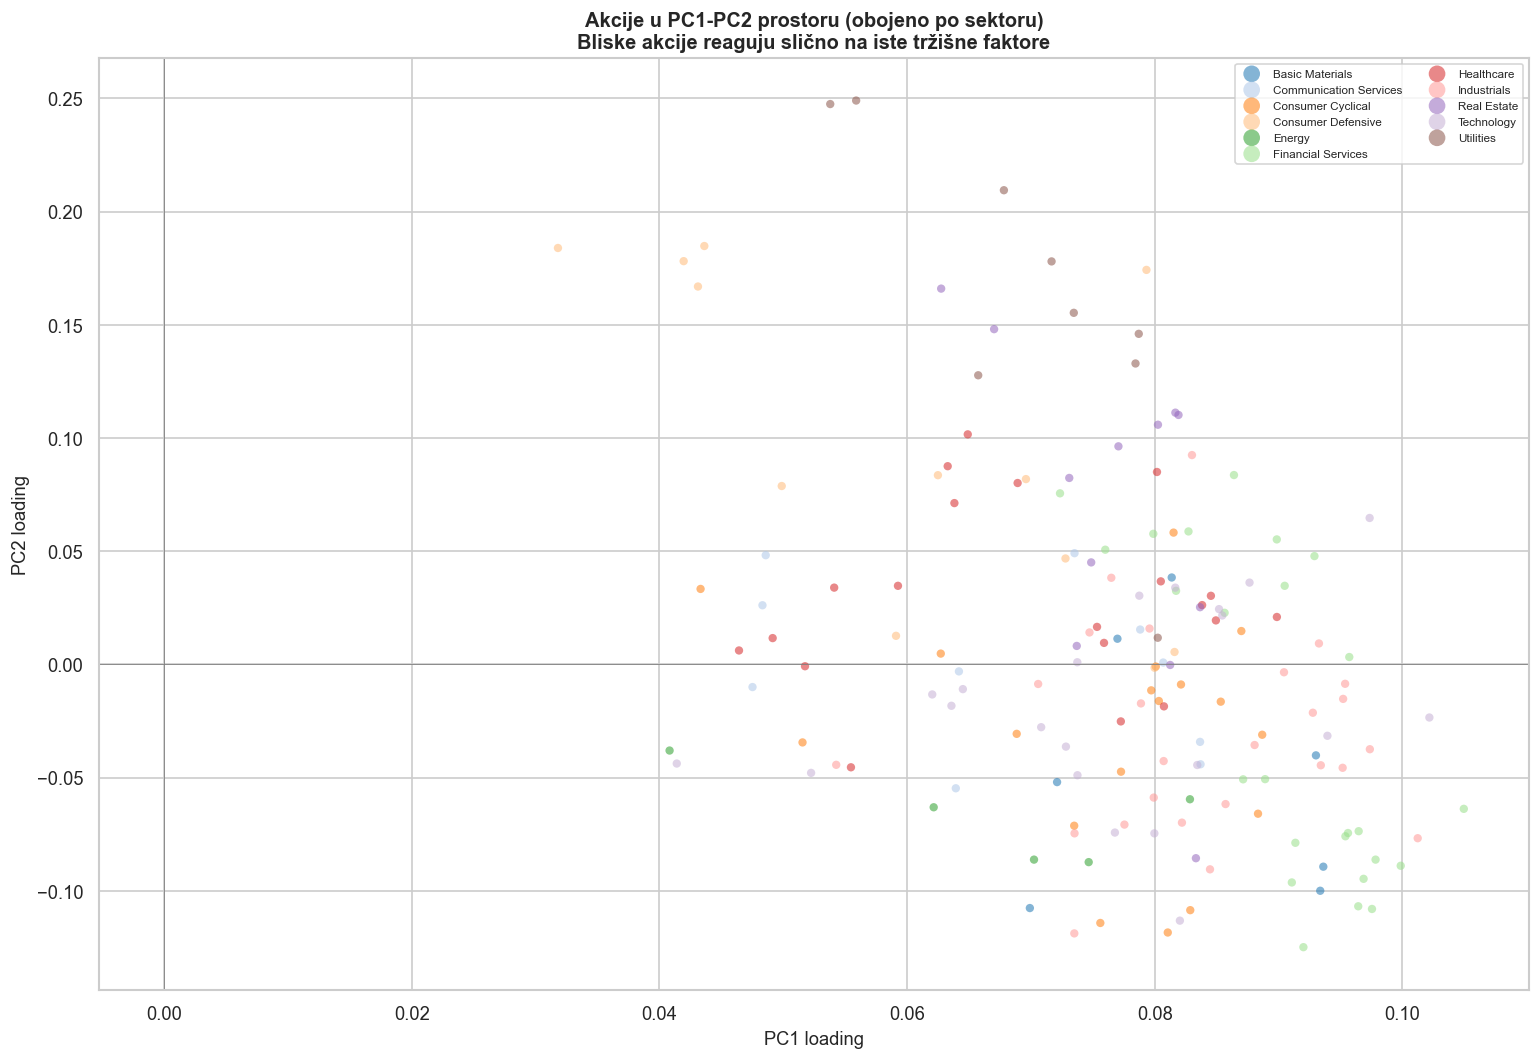

In [58]:
plot_akcije_pc_prostor(loadings, companies_pca, pc_x='PC1', pc_y='PC2')

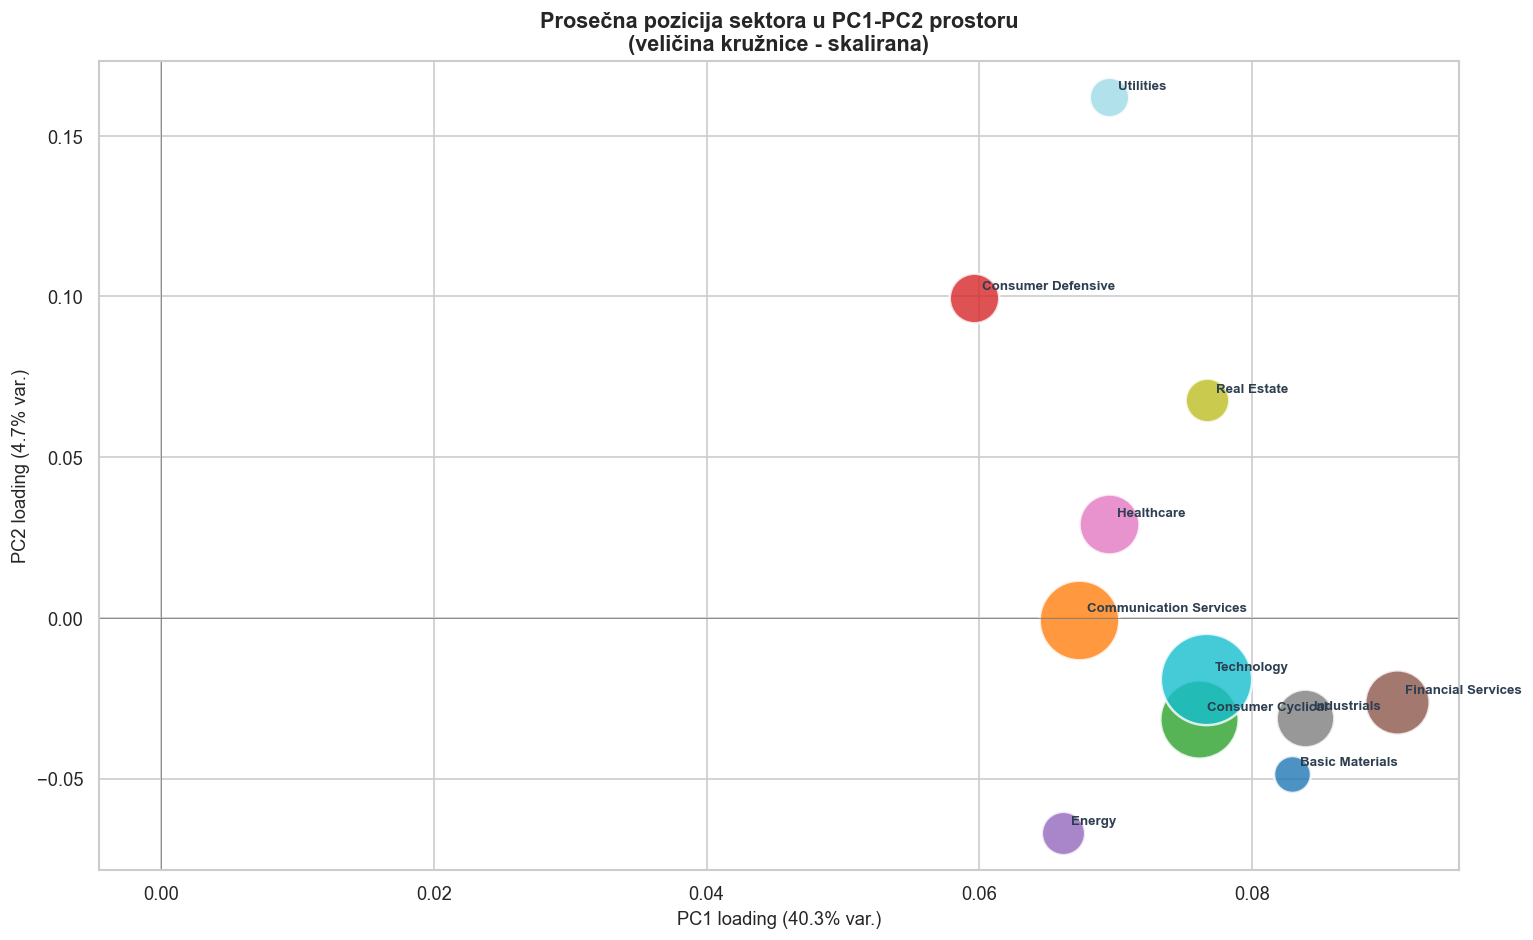

In [59]:
plot_sektorski_pc_prostor(loadings, companies_pca, pca)

### 7.9 Rolling PCA – kako se varijansa tržišta menja tokom vremena?

Ovo je centralni vremenski aspekt analize. Fitujemo PCA na prozoru od 252 dana
(≈ 1 godina), pomičemo za 21 dan (≈ 1 trading mesec) i pratimo kako se **PC1 objašnjena varijansa** menja kroz vreme.

**Ključna hipoteza:** Tokom kriza (COVID 2020, inflacioni period 2022) akcije postaju
više korelirane → PC1 objašnjava veći deo varijanse → sistemski rizik dominira.
U mirnim periodima → PC1 opada.


In [60]:
# Pokrećemo na celom skupu (train + val + test) za pun vremenski pregled
returns_all = returns  # ceo period

df_rolling = rolling_pca_variance(
    returns_all,
    window=252,   # 1 trading godina
    n_components=5,
    step=21,      # pomak od ~1 mesec
)

Rolling PCA: window=252 dana, step=21 dana
  Ukupno koraka: 107
  20/107 koraka...
  40/107 koraka...
  60/107 koraka...
  80/107 koraka...
  100/107 koraka...
  Rolling PCA završen.


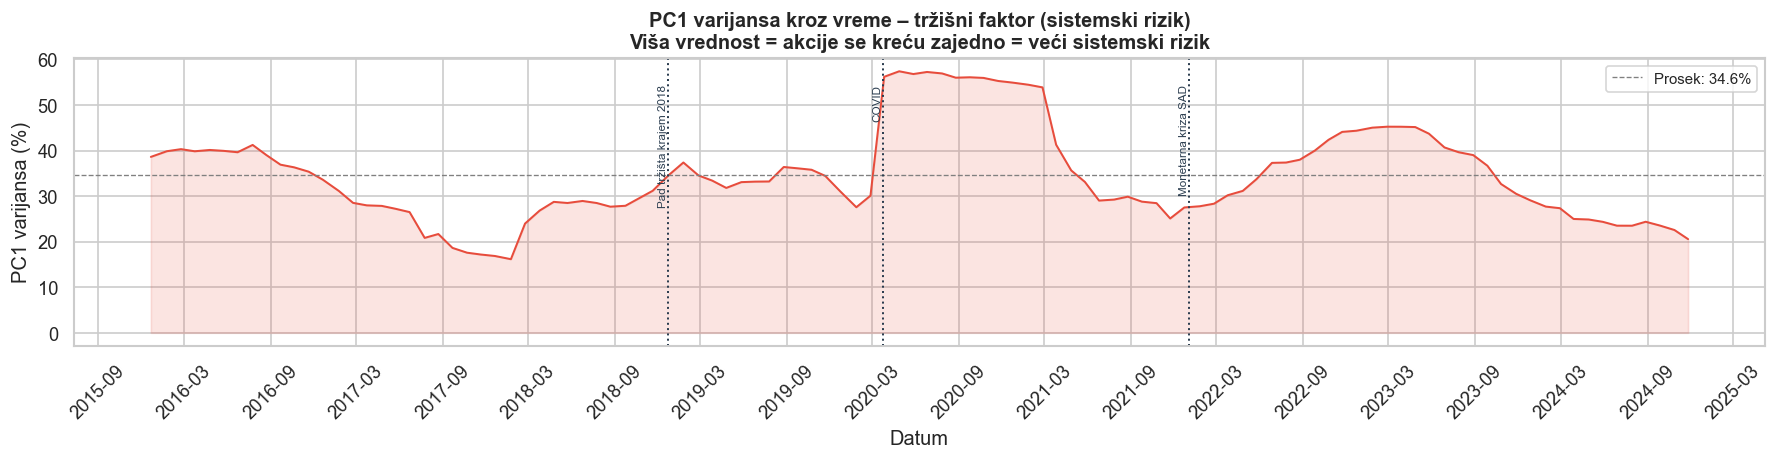

In [61]:
# PC1 kroz vreme – tržišni faktor i krizni periodi
plot_rolling_pc1(df_rolling)

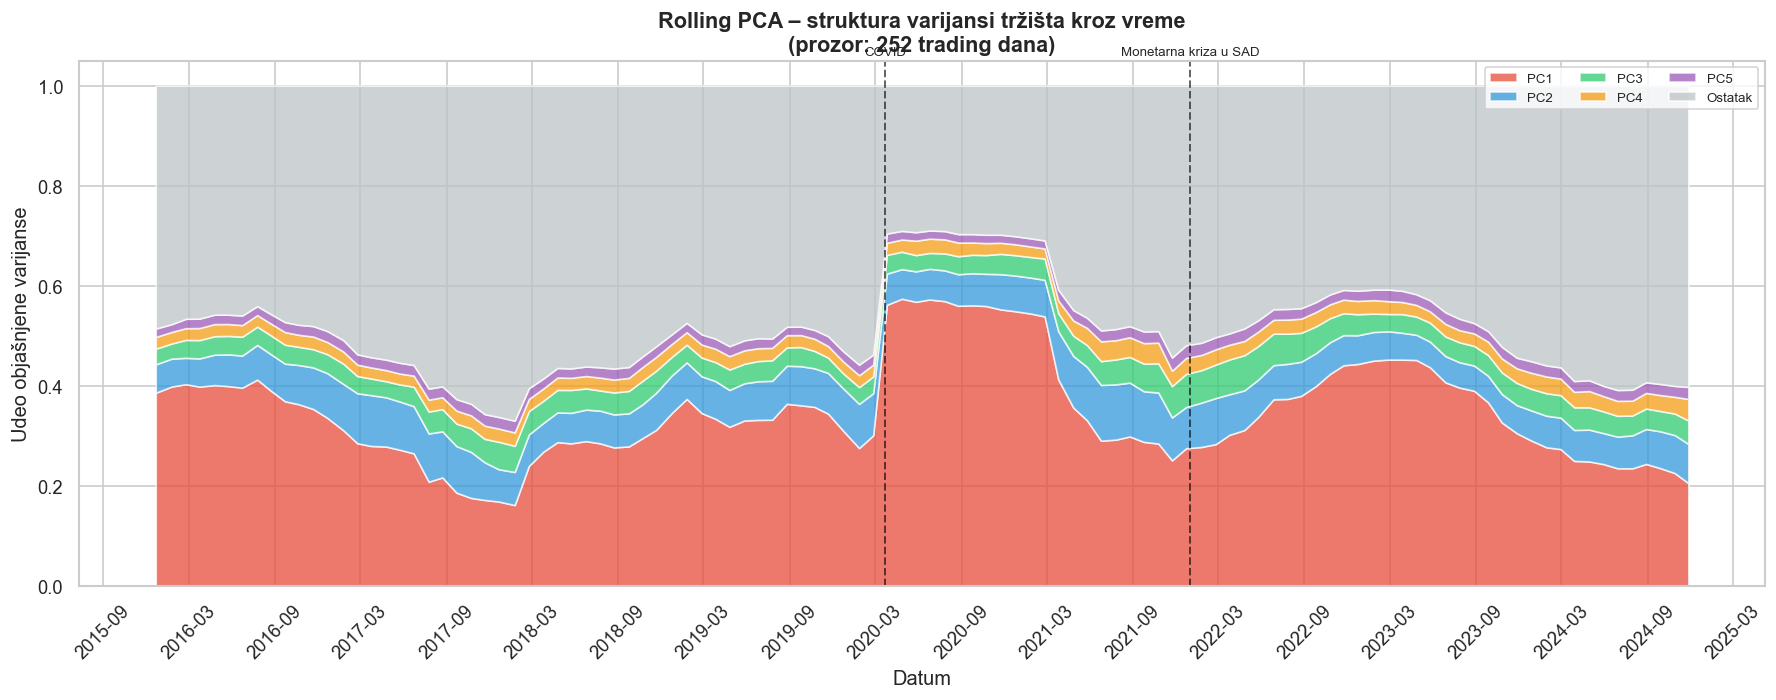

In [62]:
# Stacked prikaz varijanse kroz vreme
plot_rolling_stacked(df_rolling, n_pc=5)

### Zaključak sekcije 7

PCA na matrici dnevnih log-returns S&P 500 akcija dala je jasne odgovore na istraživačka pitanja:

**Koje akcije i sektori doprinose varijansi tržišta?**  
PC1 (tržišni faktor) zahvata sistemski rizik koji pogađa sve akcije podjednako – svi sektori
imaju pozitivan loading, što znači da kada tržište pada svi padaju zajedno. 

PC2 (kontrastni faktor)  razdvaja sektore na suprotne strane: tipično Energy/Financials nasuprot Technology/Consumer Discretionary,
što odražava ciklički vs. growth raspored kompanija. Utilities i Consumer Defensive su pozitivni, Energy negativan, Technology i Financial Services blago negativni. Upravo ta podela stvara široki vizuelni opseg na y osi - kontrast.

**Kako se doprinos menja tokom vremena?**  
Rolling PCA jasno pokazuje spike PC1 varijanse u kriznim periodima – COVID (mart 2020) i
inflacioni šok (2022) su praćeni naglim rastom korelacije između akcija. U stabilnim periodima (2016–2019, 2023) PC1 opada jer svaka kompanija počinje da se kreće po svojoj logici, nezavisno od opšteg tržišnog kretanja. Ovo potvrđuje da raspoređivanje ulaganja na više kompanija i sektora smanjuje rizik u mirnim vremenima, ali ne i tokom kriza – kada sve akcije padaju zajedno, a raznolikost akcija (ukoliko je inverstitor uložio u više različitih) prestaje da štiti investitora upravo onda kada mu je najpotrebnija.


---
## 8. Komparativna evaluacija i zaključak

### 8.1 Komparacija ARIMA vs Prophet – metrike predikcije log-returns


In [63]:
from src.evaluation import compare_models

tabela_komparacije = compare_models([
    arima_val_metrike.assign(Skup='Validacioni'),
    prophet_val_metrike.assign(Skup='Validacioni'),
    arima_test_metrike.assign(Skup='Test'),
    prophet_test_metrike.assign(Skup='Test'),
])

print("Komparativna tabela metrika predikcije (log-returns):")
print("(Napomena: MAE i RMSE su u skali log-returns, ~0.005 odgovara ~0.5% dnevnoj grešci)")
display(tabela_komparacije)


Komparativna tabela metrika predikcije (log-returns):
(Napomena: MAE i RMSE su u skali log-returns, ~0.005 odgovara ~0.5% dnevnoj grešci)


MAE      RMSE    MASE         Skup
Model                                                               
ARIMA(3, 0, 2) – Validation  0.006716  0.008487  0.5979  Validacioni
Prophet (val)                0.006516  0.008311  0.5801  Validacioni
ARIMA(3, 0, 2) – Test        0.005994  0.008131  0.5448         Test
Prophet (test)               0.005853  0.007966  0.5320         Test

### 8.2 Vizuelno poređenje predikcija na test skupu


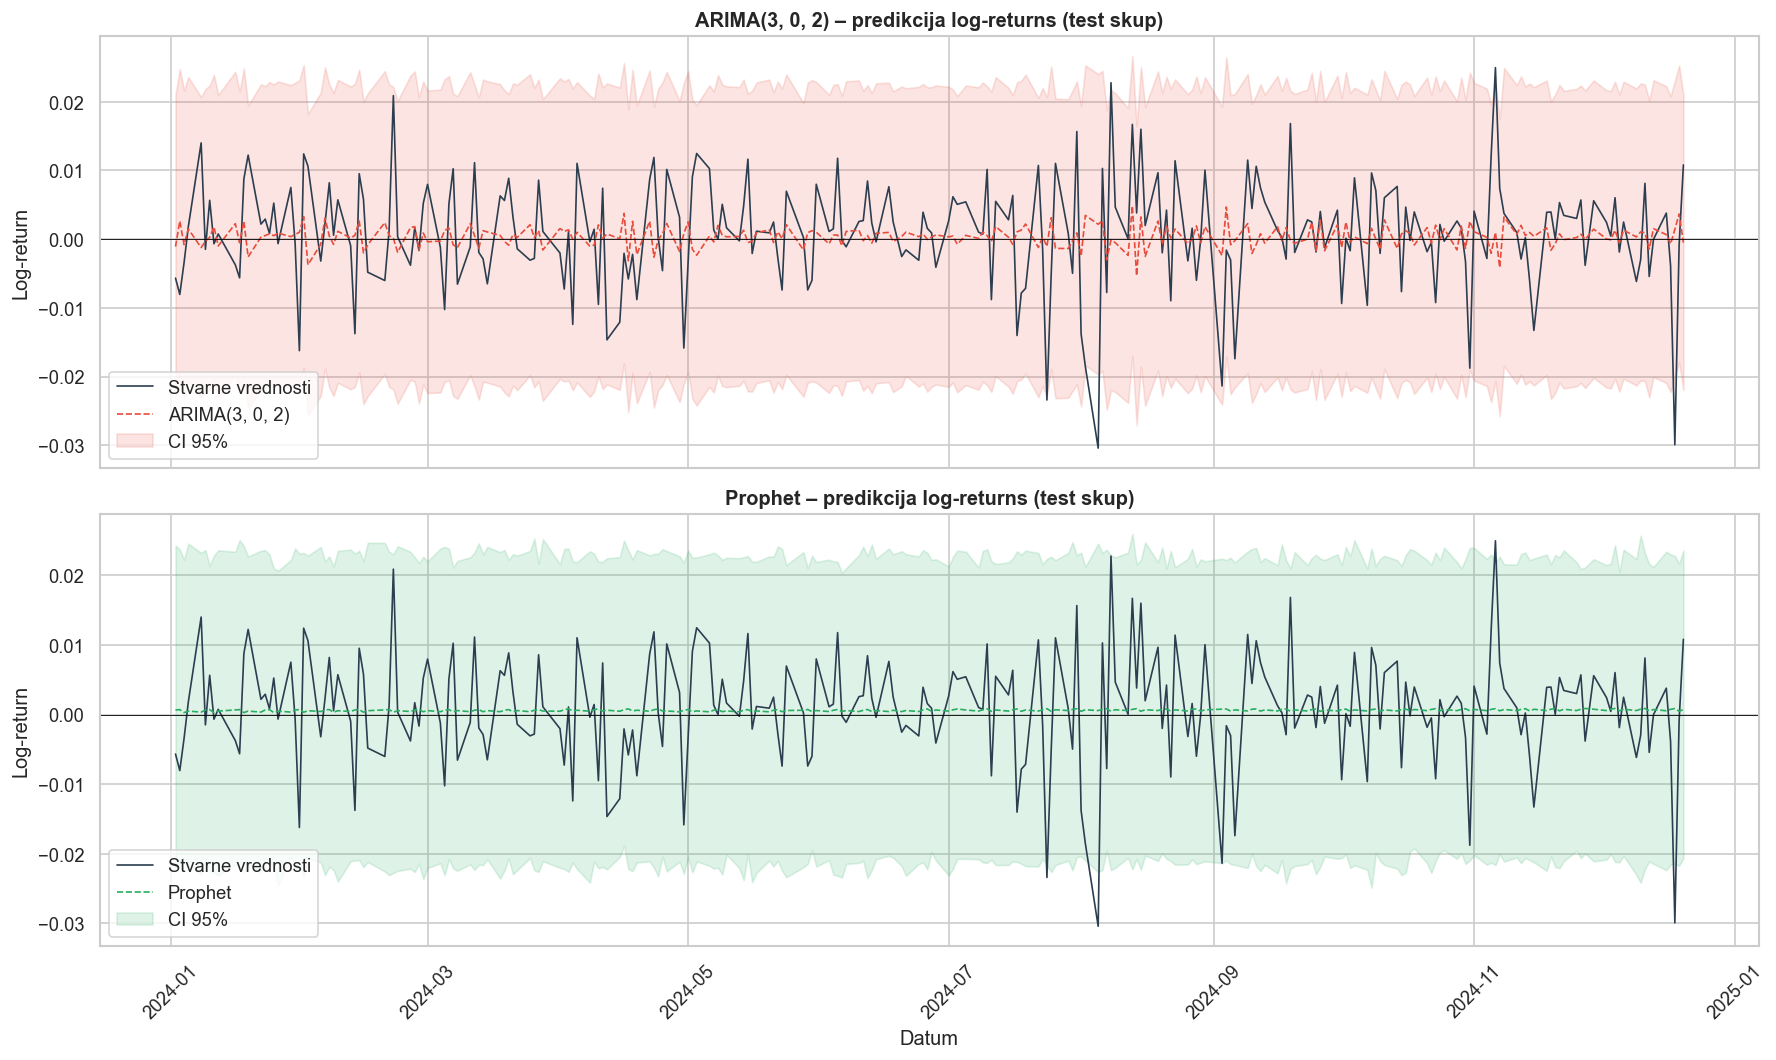

In [64]:
fig, axes = plt.subplots(2, 1, figsize=(15, 9), sharex=True)

# ARIMA
axes[0].plot(arima_test_rezultati.index, arima_test_rezultati['y_true'],
             color='#2c3e50', linewidth=1.0, label='Stvarne vrednosti')
axes[0].plot(arima_test_rezultati.index, arima_test_rezultati['y_pred'],
             color='#e74c3c', linewidth=1.0, linestyle='--',
             label=f'ARIMA{finalni_order}')
axes[0].fill_between(arima_test_rezultati.index,
                      arima_test_rezultati['lower_95'],
                      arima_test_rezultati['upper_95'],
                      color='#e74c3c', alpha=0.15, label='CI 95%')
axes[0].set_title(f'ARIMA{finalni_order} – predikcija log-returns (test skup)',
                   fontsize=12, fontweight='bold')
axes[0].set_ylabel('Log-return')
axes[0].legend()
axes[0].axhline(0, color='black', linewidth=0.5)

# Prophet
axes[1].plot(prophet_test_rezultati.index, prophet_test_rezultati['y_true'],
             color='#2c3e50', linewidth=1.0, label='Stvarne vrednosti')
axes[1].plot(prophet_test_rezultati.index, prophet_test_rezultati['y_pred'],
             color='#27ae60', linewidth=1.0, linestyle='--', label='Prophet')
axes[1].fill_between(prophet_test_rezultati.index,
                      prophet_test_rezultati['lower_95'],
                      prophet_test_rezultati['upper_95'],
                      color='#27ae60', alpha=0.15, label='CI 95%')
axes[1].set_title('Prophet – predikcija log-returns (test skup)',
                   fontsize=12, fontweight='bold')
axes[1].set_ylabel('Log-return')
axes[1].set_xlabel('Datum')
axes[1].legend()
axes[1].axhline(0, color='black', linewidth=0.5)

import matplotlib.dates as mdates
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 8.3 Zaključak projekta

#### Odgovori na istraživačka pitanja

**1. Da li S&P 500 pokazuje stabilne trendove i obrasce?**  
Originalne vrednosti indeksa pokazuju jasan rastući trend (2014–2024), ali nisu stacionarne. Logaritamski prinosi su stacionarni, ali dominantno šum. ADF test i Ljung-Box test potvrđuju stacionarnost uz prisustvo slabe linearne autokorelacije. STL dekompozicija pokazala je da rezidualna komponenta dominira serijom.

**2. Kako se pokazatelji ponašaju u različitim tržišnim periodima?**  
COVID kriza (mart 2020) i inflacija (2022) jasno su vidljivi kao periodi visoke volatilnosti na grafiku pokretne standardne devijacije i uslovne volatilnosti GARCH modela. Distribucija log-returns ima debele repove (pozitivna kurtoza = leptokurtičnost) što potvrđuju ovi ekstremni događaji.

**3. Koji model preciznije predviđa log-returns?**  
Oba modela (ARIMA i Prophet) daju slične metrike jer log-returns su blizu belog šuma – nema pouzdanog linearnog signala koji se može iskoristiti za predikciju. MASE ≈ 0.56 potvrđuje da su modeli bolji od naivnog prediktora. Ovo je konzistentno sa Hipotezom efikasnog tržišta (EMH).

**4. Kako GARCH opisuje volatilnost?**  
GARCH(1,1) sa Skewed Student-t distribucijom uspešno modeluje **volatility clustering** – pojavu da visoka volatilnost prati visoku volatilnost. Uslovna volatilnost σ_t precizno prati poznate tržišne šokove. Suma koeficijenata α+β bliska 1.0 ukazuje na **visoku perzistentnost volatilnosti** – šokovi se dugo "pamte" i potrebno je vreme da se prevaziđu.

**5. Koje kompanije i sektori dominiraju?**  
PC1 analiza pokazuje da Financial Services i Industrials sektori imaju najveći prosečni loading na tržišnom faktoru, što znači da njihove akcije najsnažnije prate opšte tržišno kretanje. Technology sektor je tek na petom mestu. PC2 otkriva jasnu podelu između sektora (Utilities, Consumer Defensive — pozitivni loadinzi) i sektora kao što su (Energy, Financial Services, Industrials — negativni loadinzi), što odražava klasičnu podelu između kompanija otpornih na recesiju i onih čije poslovanje zavisi od ekonomskog ciklusa.

#### Ograničenja projekta

- Log-returns su dominantno beli šum → linearni modeli ne mogu pouzdano predviđati log-returns i vrednost indeksa
- GARCH predviđa nivo rizika, ali ne i smer – za trading strategije potrebni su dodatni modeli
- Prophet je dizajniran za poslovne serije sa jakim sezonalnostima; log-returns su dominantno šum sa blagom linearnom autokorelacionom strukturom i blagom sezonalnošću

#### Tehnologije

Python | Jupyter Notebook | Pandas | NumPy | Statsmodels | pmdarima | arch | Prophet | scikit-learn | Matplotlib | Seaborn
